In [1]:
#Importing Modules

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import HeatMapWithTime

from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost
import lightgbm as lgb

# 1. Analysis and Visualization

In [2]:
df_test_analysis = pd.read_csv("../data/week5/test.csv")
df_train_analysis = pd.read_csv("../data/week5/train.csv")
df_sub_analysis = pd.read_csv("../data/week5/submission.csv")
lockdown_analysis = pd.read_csv('../data/week4/countryLockdowndates.csv')
testing_worldwide_analysis = pd.read_csv('../data/external/tested_worldwide.csv')
coords_analysis = pd.read_csv('../data/external/region_metadata.csv')

In [3]:
# Check for null values

df_train_analysis.apply(lambda x: x.isnull().sum()/len(x))

Id                0.000000
County            0.092405
Province_State    0.053999
Country_Region    0.000000
Population        0.000000
Weight            0.000000
Date              0.000000
Target            0.000000
TargetValue       0.000000
dtype: float64

In [4]:
print(df_train_analysis.head())

print('----------------------------')

print(df_train_analysis.describe())

   Id County Province_State Country_Region  Population    Weight        Date  \
0   1    NaN            NaN    Afghanistan    27657145  0.058359  2020-01-23   
1   2    NaN            NaN    Afghanistan    27657145  0.583587  2020-01-23   
2   3    NaN            NaN    Afghanistan    27657145  0.058359  2020-01-24   
3   4    NaN            NaN    Afghanistan    27657145  0.583587  2020-01-24   
4   5    NaN            NaN    Afghanistan    27657145  0.058359  2020-01-25   

           Target  TargetValue  
0  ConfirmedCases          0.0  
1      Fatalities          0.0  
2  ConfirmedCases          0.0  
3      Fatalities          0.0  
4  ConfirmedCases          0.0  
----------------------------
                  Id    Population         Weight    TargetValue
count  935010.000000  9.350100e+05  935010.000000  935010.000000
mean   484815.500000  2.720127e+06       0.530870      12.105479
std    279911.106373  3.477771e+07       0.451909     293.408777
min         1.000000  8.600000e+

In [5]:
df_train_analysis['Date'] = pd.to_datetime(df_train_analysis['Date'])
df_test_analysis['Date'] = pd.to_datetime(df_test_analysis['Date'])

In [6]:
# Getting the confirmed cases out of the training data

cases_train = df_train_analysis[df_train_analysis['Target'] == 'ConfirmedCases'].drop(['Target'], axis = 1).rename(
    columns = {'TargetValue': 'ConfirmedCases'})

In [7]:
cases_train.head()

Id County Province_State Country_Region  Population    Weight       Date  \
0   1    NaN            NaN    Afghanistan    27657145  0.058359 2020-01-23   
2   3    NaN            NaN    Afghanistan    27657145  0.058359 2020-01-24   
4   5    NaN            NaN    Afghanistan    27657145  0.058359 2020-01-25   
6   7    NaN            NaN    Afghanistan    27657145  0.058359 2020-01-26   
8   9    NaN            NaN    Afghanistan    27657145  0.058359 2020-01-27   

   ConfirmedCases  
0             0.0  
2             0.0  
4             0.0  
6             0.0  
8             0.0

In [8]:
# Getting Fatalities data out of training data.

fatal_train = df_train_analysis[df_train_analysis['Target'] == 'Fatalities'].drop(['Target'], axis = 1).rename(
    columns = {'TargetValue': 'Fatalities'})

In [9]:
fatal_train.head()

Id County Province_State Country_Region  Population    Weight       Date  \
1   2    NaN            NaN    Afghanistan    27657145  0.583587 2020-01-23   
3   4    NaN            NaN    Afghanistan    27657145  0.583587 2020-01-24   
5   6    NaN            NaN    Afghanistan    27657145  0.583587 2020-01-25   
7   8    NaN            NaN    Afghanistan    27657145  0.583587 2020-01-26   
9  10    NaN            NaN    Afghanistan    27657145  0.583587 2020-01-27   

   Fatalities  
1         0.0  
3         0.0  
5         0.0  
7         0.0  
9         0.0

In [10]:
## For bar graphs

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width()
            _y = p.get_y() + p.get_height()/2 
            value = '{:.2f}'.format(-p.get_width())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [11]:
def Find_pattern (df, list_of_countries, pattern):
    
    list_matches = []
    
    for country in list_of_countries:
    
        cntry = df[df['Country_Region'] == country]
        cntry['changes_bool'] = cntry['changes'] < 0
    
        matches = [cntry.index[i - len(pattern)] 
         for i in range(len(pattern), len(cntry))
         if all(cntry['changes_bool'][i-len(pattern):i] == pattern)]
        
        if len(matches) > 0:
            list_matches += matches
        
    return list_matches

In [12]:
def Graph_covid (df, country, date = None):
    plt.figure(figsize = (15, 10))
   
    ax = sns.lineplot(x = 'Date', y = 'ConfirmedCases', data = df, label = 'Confirmed Cases', color = 'grey')
    ax.fill_between(df['Date'], df['ConfirmedCases'], color = 'silver')
    
    
    ax1 = ax.twinx()
    sns.lineplot(x = 'Date', y = 'mortality', data = df, label = 'Mortality rate', ax = ax1, color = 'k')
    
    if date != None:
        fm_date = pd.to_datetime(date)
        ax.axvline(fm_date, color = 'red')
    
        # Annotate

        ymin, ymax = plt.ylim()
        text = 'National lockdown \n' + date
        ax.annotate(text,
                xy  = (fm_date, ymax),
                xycoords='data',
                xytext=(10, 10), textcoords='offset points',
                annotation_clip=False,
                arrowprops = {'width': 1, 'headwidth': 1, 'headlength': 1, 'shrink':0.05},
                fontsize=12)
    
    plt.title(country)
    plt.show()

In [13]:
def Graph_changes (df, country, num_day, ax = None, **kwargs):
    
    ax = ax or plt.gca()
    
    cntry = df[df['Country_Region'] == country]

    ax.plot(cntry['Date'], cntry['changes'], linewidth = 3, **kwargs)
    ax.axhline(0, color = 'k')
    return ax.set_title('Changes in confirmed cases in ' + country)

In [14]:
def Graph_testing_data (df, country):
    
    cntry = df[df['Country_Region'] == country]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey = False, figsize = (20, 10))
    
    ax1.fill_between(cntry['Date'], cntry['total_tested'], color = 'silver', 
                    label = 'Total tested')
    ax1.fill_between(cntry['Date'], cntry['positive'], color = 'tomato',
                    label = 'Total positive')
    ax1.set_title('Number of tests and positive cases')
    ax1.legend()
   
    ax2.fill_between(cntry['Date'], cntry['positive'], color = 'tomato',
                    label = 'Total positive')
    ax2.fill_between(cntry['Date'], cntry['recovered'], color = 'lightgreen',
                    label = 'Total recoveries')
    ax2.set_title('Number of positve cases and recoveries')
    ax2.legend()

    plt.suptitle(country)
    
    return ax1, ax2

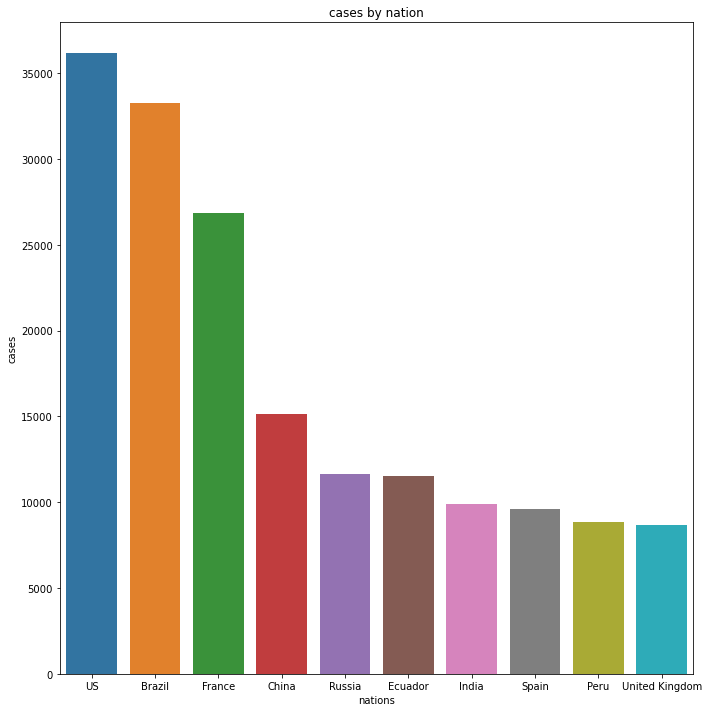

In [15]:
## Confimed cases in top 10 countries

top_countries_cc = cases_train.groupby(['Country_Region'])['ConfirmedCases'].max()
top_10_cases = top_countries_cc.sort_values(ascending = False).head(10)
ten_nations_cases = [x for x in top_10_cases.index if top_10_cases[x]] 

barplot_df = pd.DataFrame({
    'nations': ten_nations_cases,
    'cases': [top_10_cases[x] for x in top_10_cases.index if top_10_cases[x]]
})
plt.figure(figsize=(10, 10))
sns.barplot(x="nations", y="cases", data = barplot_df.sort_values(by='cases', ascending=False))
plt.title('cases by nation')
plt.tight_layout()
plt.show()


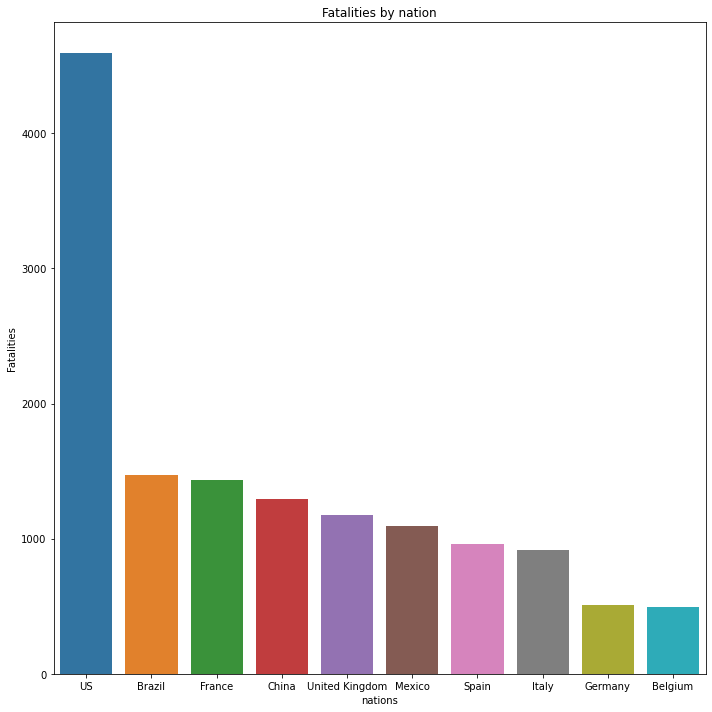

In [16]:
## Fatalities in top 10 countries

top_countries_fat = fatal_train.groupby(['Country_Region'])['Fatalities'].max()
top_10_fatalities = top_countries_fat.sort_values(ascending = False).head(10)
ten_nations_fatalities = [x for x in top_10_fatalities.index if top_10_fatalities[x]] 

barplot_df = pd.DataFrame({
    'nations': ten_nations_fatalities,
    'Fatalities': [top_10_fatalities[x] for x in top_10_fatalities.index if top_10_fatalities[x]]
})
plt.figure(figsize=(10, 10))
sns.barplot(x="nations", y="Fatalities", data = barplot_df.sort_values(by='Fatalities', ascending=False))
plt.title('Fatalities by nation')
plt.tight_layout()
plt.show()


In [17]:
cases_by_date = cases_train.groupby(['Country_Region', 'Date'], as_index = False).sum()
deaths_by_date = fatal_train.groupby(['Country_Region', 'Date'], as_index = False).sum()

## Extract countries with the most number of confirmed cases as of May 10, 2020
top10_cc = cases_by_date[cases_by_date['Date'] == cases_by_date['Date'].max()].sort_values(['ConfirmedCases'],
                                                                                      ascending = False)['Country_Region'][:10]
print(top10_cc)

print('-----------------------------------------')

## Extract countries with the most number of Fatalities as of May 10, 2020
top10_fat = deaths_by_date[deaths_by_date['Date'] == deaths_by_date['Date'].max()].sort_values(['Fatalities'],
                                                                                      ascending = False)['Country_Region'][:10]
print(top10_fat)

23489            US
10799         India
18899        Russia
15254        Mexico
4859          Chile
18089          Peru
17549      Pakistan
5129       Colombia
11069          Iran
1889     Bangladesh
Name: Country_Region, dtype: object
-----------------------------------------
23489                US
15254            Mexico
24029    United Kingdom
10799             India
18899            Russia
18089              Peru
4454             Canada
5129           Colombia
4859              Chile
11609             Italy
Name: Country_Region, dtype: object


Text(0.5, 1.0, 'Confirmed cases in the US by state')

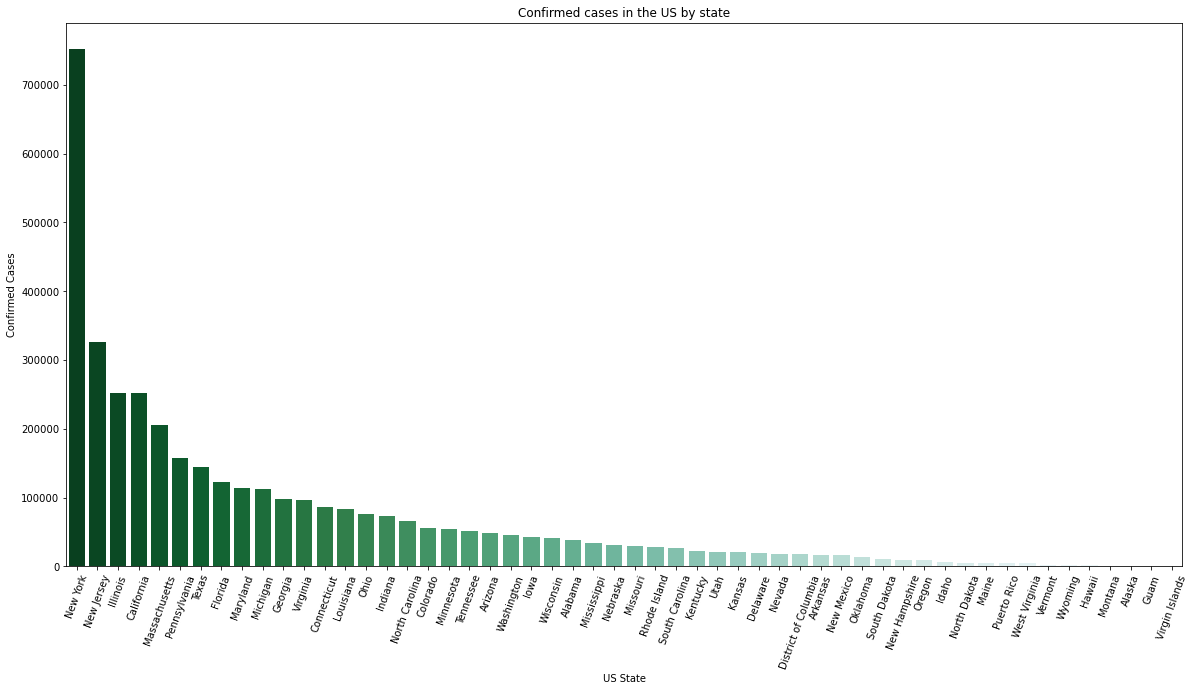

In [18]:
## Confimed cases in US states

plt.figure(figsize = (20, 10))
gb_us = cases_train[cases_train['Country_Region'] == 'US'].groupby(['Province_State']).sum().sort_values(['ConfirmedCases'], 
                                                                                                        ascending = False)
sns.barplot(x = gb_us.index, y = 'ConfirmedCases', data = gb_us, palette = 'BuGn_r')

plt.xticks(rotation = 70)
plt.xlabel('US State')
plt.ylabel('Confirmed Cases')
plt.title('Confirmed cases in the US by state')

In [19]:
## grab the states' populations 

gb_us.drop(['Population'], axis = 1, inplace = True)
state_pop = cases_train[cases_train['Country_Region'] == 'US'][['Province_State', 'Population']].drop_duplicates().groupby(['Province_State']).sum()
gb_us = gb_us.merge(state_pop, how = 'outer', right_index = True, left_index = True)

Text(0.5, 1.0, 'Number of cases per 10000 people in the US by state')

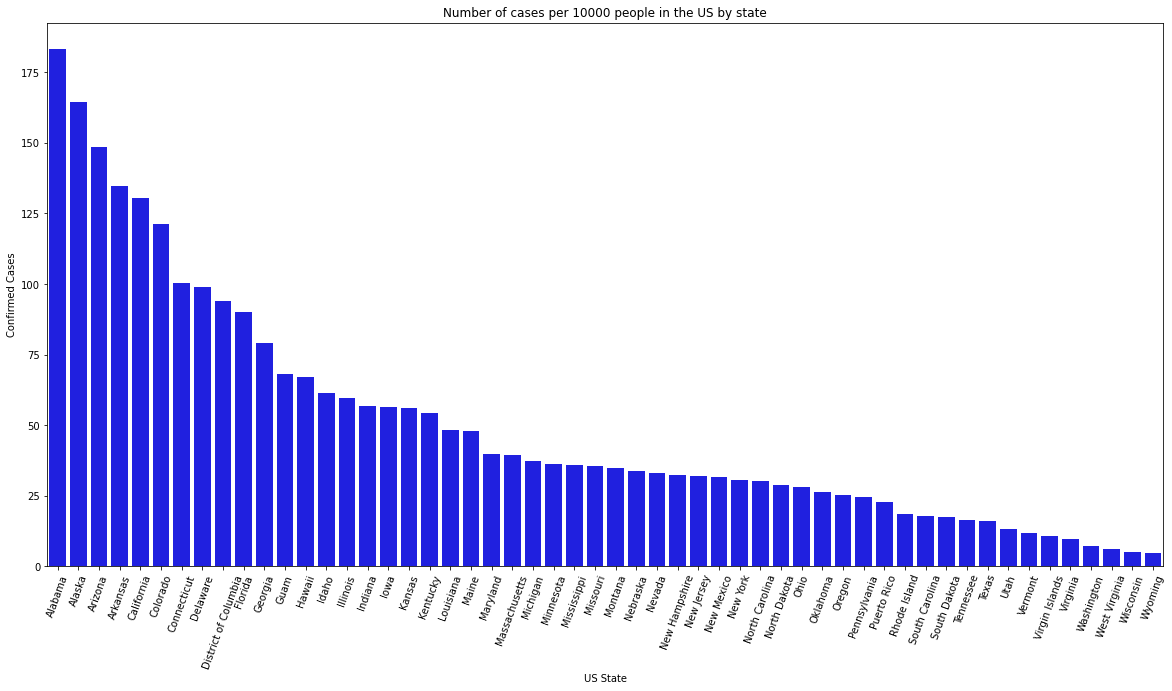

In [20]:
## Number of cases per 10,000 people

gb_us['cases per 10000'] = gb_us['ConfirmedCases']/gb_us['Population']*10000

plt.figure(figsize = (20, 10))
ax = sns.barplot(x = gb_us.index, y = 'cases per 10000', data = gb_us.sort_values(['cases per 10000'], ascending = False), color = 'b')

plt.xticks(rotation = 70)
plt.xlabel('US State')
plt.ylabel('Confirmed Cases')
plt.title('Number of cases per 10000 people in the US by state')


In [21]:
## US states coordinates

us_coords = coords_analysis[coords_analysis['Country_Region'] == 'US'].set_index(['Province_State']).drop(['population', 'area',
                                                                                     'continent', 'Country_Region'], axis = 1)
gb_us = gb_us.merge(us_coords, how = 'outer', left_index = True, right_index = True)
gb_us.dropna(axis = 0, inplace = True)
gb_us.head()                                     

Id       Weight  ConfirmedCases  Population  \
Province_State                                                          
Alabama         7.093845e+08   869.988772         38460.0   9791056.0   
Alaska          3.685298e+08   460.430840          1046.0   1468983.0   
Arizona         2.104596e+08   182.957667         48878.0  14450363.0   
Arkansas        1.131832e+09  1025.241713         17058.0   6031629.0   
California      1.029197e+09   674.006382        251476.0  79069268.0   

                cases per 10000      lat       lon  density  
Province_State                                               
Alabama               39.280748  32.3182  -86.9023    36.11  
Alaska                 7.120573  61.3707 -152.4044     0.42  
Arizona               33.824756  33.7298 -111.4312    24.65  
Arkansas              28.280917  34.9697  -92.3731    21.91  
California            31.804519  36.1162 -119.6816    93.20

In [22]:
## Create an empty map

folium_map = folium.Map(location=[37.0902,-95.7129],# USA coordinates
                        zoom_start=4,tiles='openstreetmap')

for index, state in gb_us.iterrows():
    
    #add pop up
    
    popup_text = """{}, {}, {}"""
    popup_text = popup_text.format(index, state['ConfirmedCases'], state['cases per 10000'])
    
    color = 'red'
    ## Size of bubbles are number of cases
    size = state['ConfirmedCases']/10000
    
    folium.CircleMarker(location = (state['lat'], state['lon']),
                        weight=2,radius = size, color = color, opacity = 10,
                        fill = True, fill_color = color, popup = popup_text).add_to(folium_map)
    
folium_map

In [23]:
## US fatalities by states

gb_us_fatal = fatal_train[fatal_train['Country_Region'] == 'US'].groupby(['Province_State']).sum().sort_values(['Fatalities'], 
                                                                                                        ascending = False)
gb_us_tot = gb_us.merge(gb_us_fatal[['Fatalities']], how = 'left', left_index = True, right_index = True)

## to create a diverging graph
gb_us_tot['fatal_viz'] = -gb_us_tot['Fatalities']
gb_us_tot.sort_values(['ConfirmedCases'], ascending = False, inplace = True)
gb_us_tot.head()

Id       Weight  ConfirmedCases  Population  \
Province_State                                                          
New York        5.085437e+09   730.353885        752416.0  45703881.0   
New Jersey      1.712250e+09   232.514674        326269.0  17790710.0   
Illinois        3.513724e+09  1357.638225        251624.0  25412901.0   
California      1.029197e+09   674.006382        251476.0  79069268.0   
Massachusetts   8.439694e+08   162.756684        204745.0  13794652.0   

                cases per 10000      lat       lon  density  Fatalities  \
Province_State                                                            
New York             164.628470  42.1657  -74.9481   137.68     60472.0   
New Jersey           183.392906  40.2989  -74.5210   393.17     24098.0   
Illinois              99.014276  40.3495  -88.9861    84.48     11589.0   
California            31.804519  36.1162 -119.6816    93.20      9058.0   
Massachusetts        148.423461  42.2302  -71.5301   254.23     14462.0   

                fatal_viz  
Province_State             
New York         -60472.0  
New Jersey       -24098.0  
Illinois         -11589.0  
California        -9058.0  
Massachusetts    -14462.0

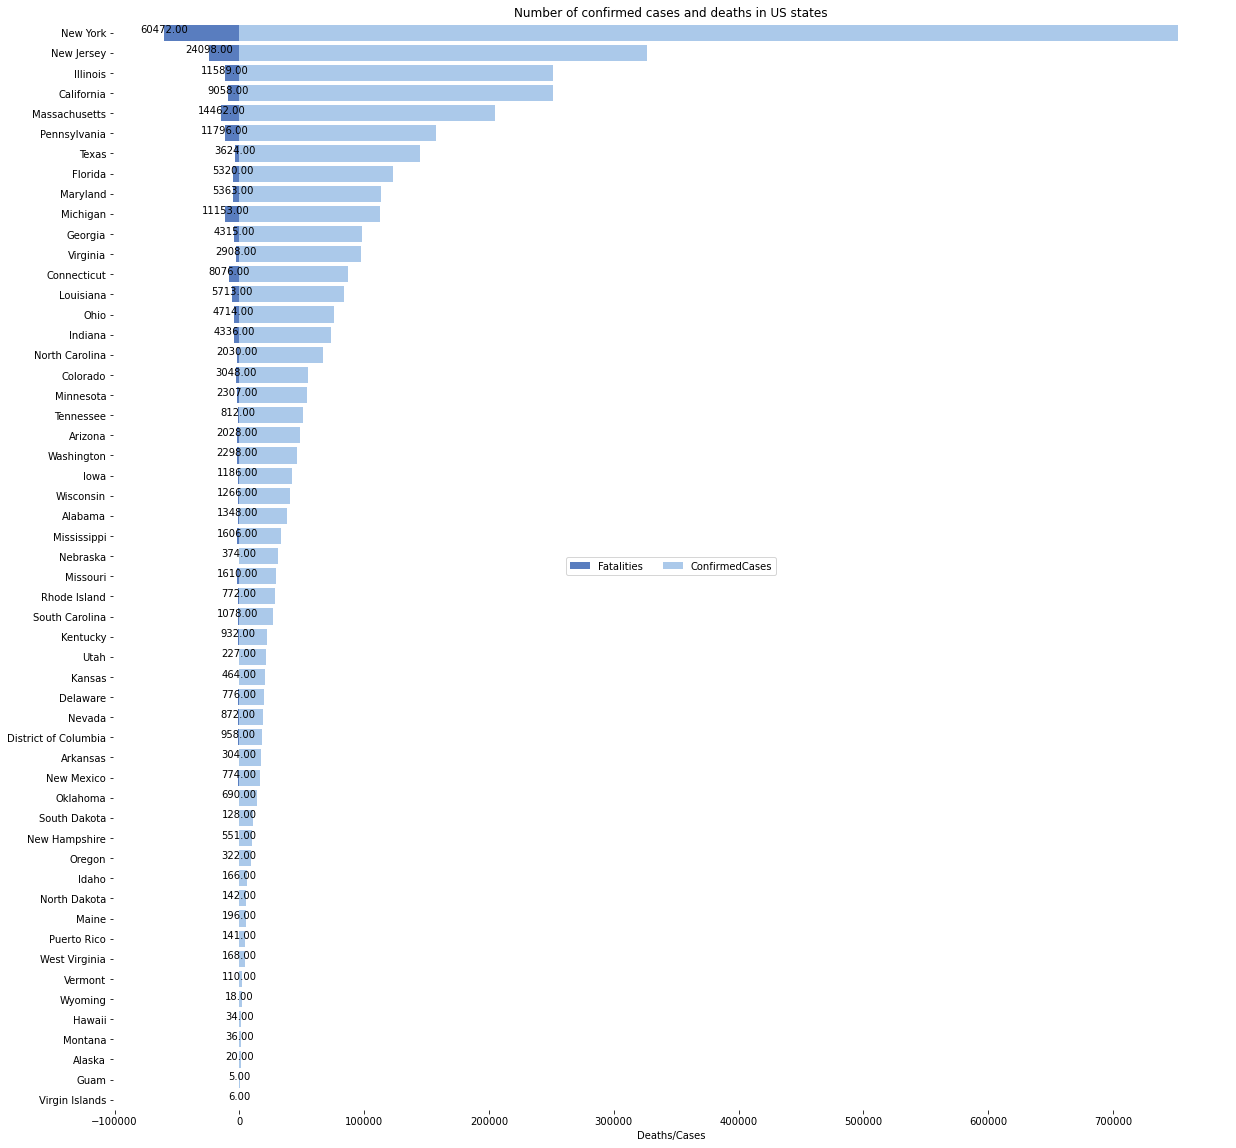

In [24]:
fig, ax = plt.subplots(figsize = (20,20))

sns.set_color_codes("muted")
sns.barplot(x = "fatal_viz", y = gb_us_tot.index, data = gb_us_tot,
            label = 'Fatalities', color = 'b')

show_values_on_bars(ax)

sns.set_color_codes("pastel")
sns.barplot(x = "ConfirmedCases", y = gb_us_tot.index, data = gb_us_tot,
            label = "ConfirmedCases", color = 'b')


ax.legend(ncol=2, loc="center", frameon=True)
ax.set(ylabel="",
       xlabel="Deaths/Cases", title = 'Number of confirmed cases and deaths in US states')

sns.despine(left=True, bottom=True)

In [25]:
## Calculate daily mortality rates

cases_by_date['mortality'] = deaths_by_date['Fatalities'] / cases_by_date['ConfirmedCases']
cases_by_date['mortality'].fillna(0, inplace = True)
cases_by_date['mortality'].replace(np.inf, 0, inplace = True)

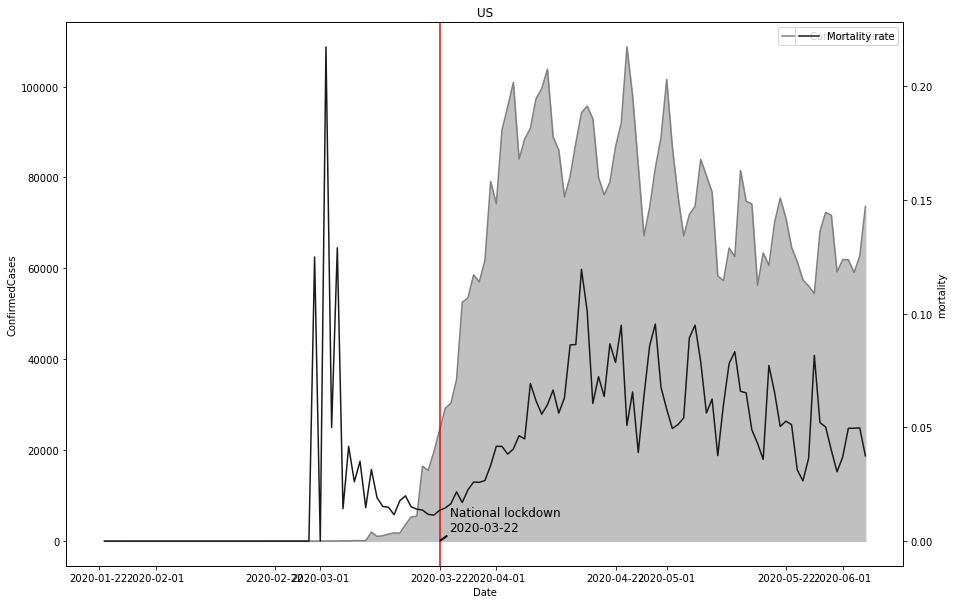

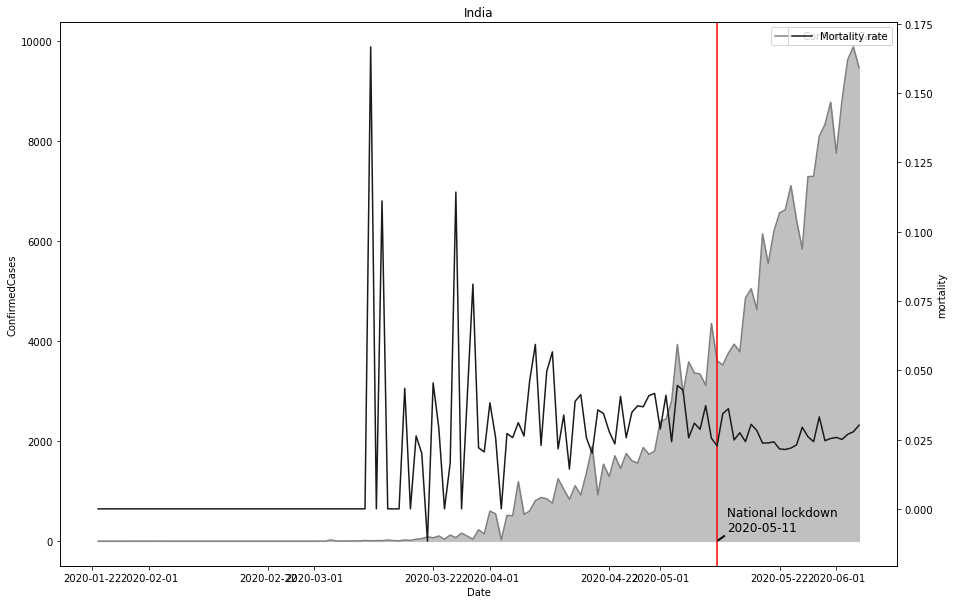

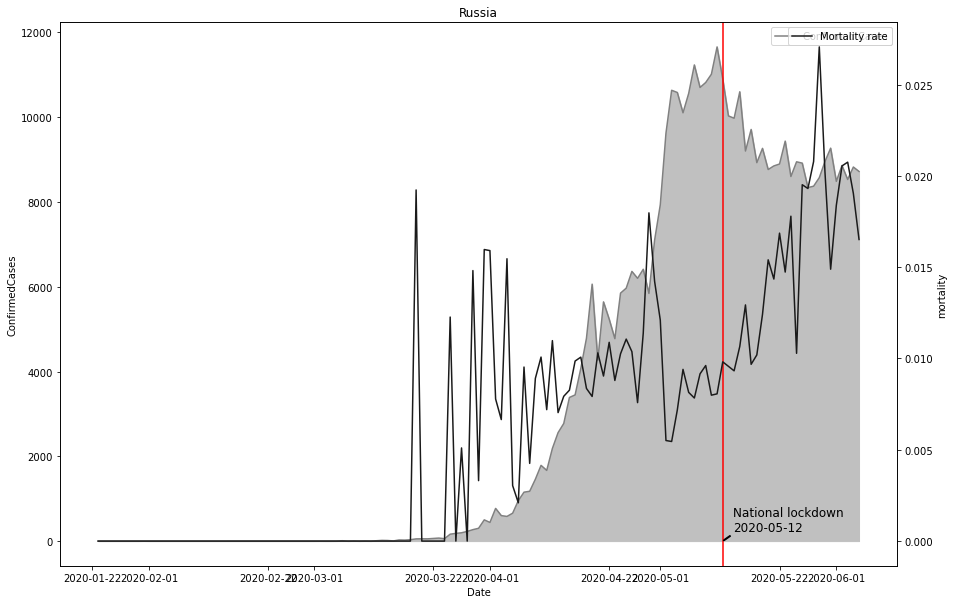

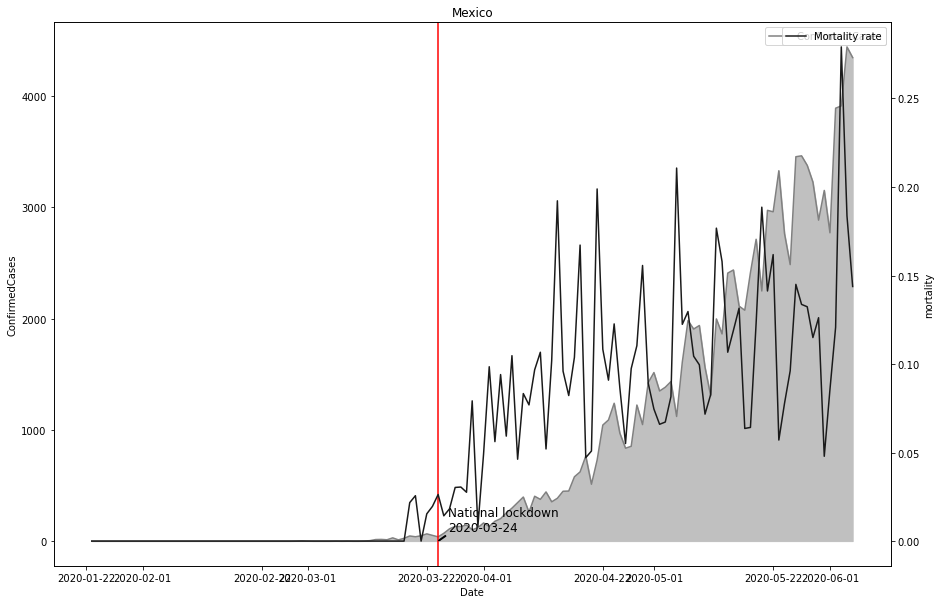

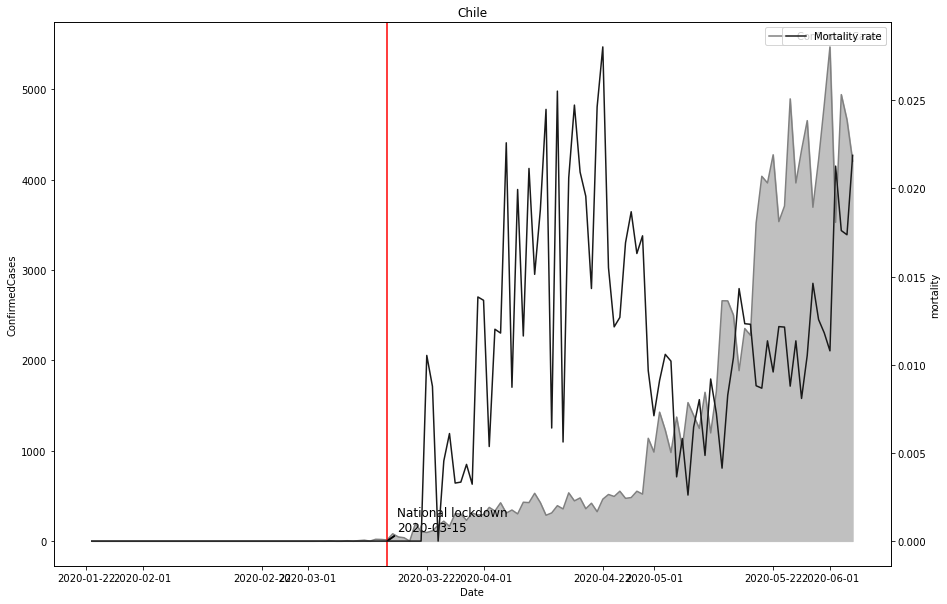

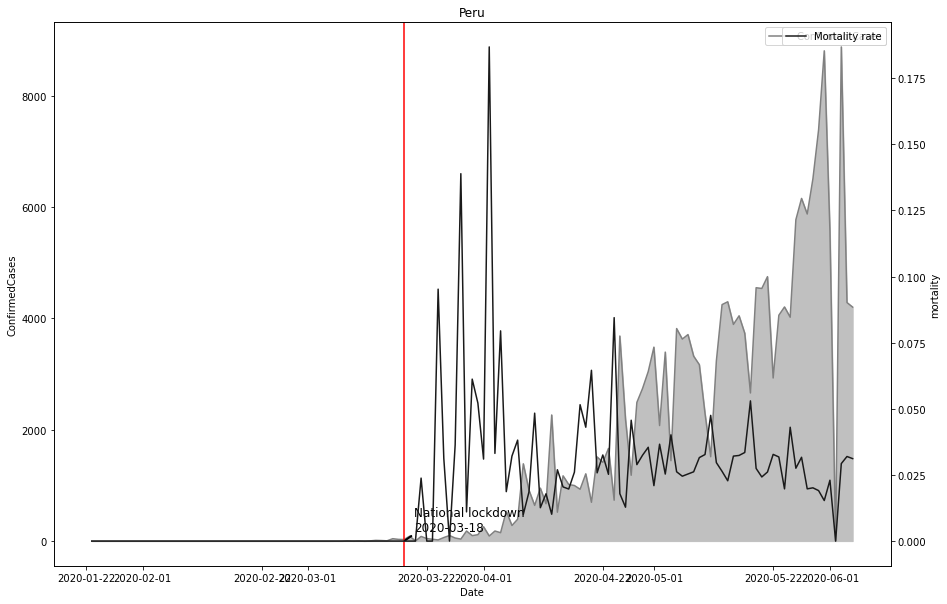

In [26]:
#plt.figure(figsize = (20, 10))

cntry1 = cases_by_date[cases_by_date['Country_Region'] == top10_cc.iloc[0]]
cntry2 = cases_by_date[cases_by_date['Country_Region'] == top10_cc.iloc[1]]
cntry3 = cases_by_date[cases_by_date['Country_Region'] == top10_cc.iloc[2]]
cntry4 = cases_by_date[cases_by_date['Country_Region'] == top10_cc.iloc[3]]
cntry5 = cases_by_date[cases_by_date['Country_Region'] == top10_cc.iloc[4]]
cntry6 = cases_by_date[cases_by_date['Country_Region'] == top10_cc.iloc[5]]

#plt.figure(figsize = (20, 10))

Graph_covid(cntry1, top10_cc.iloc[0], '2020-03-22')
Graph_covid(cntry2, top10_cc.iloc[1], '2020-05-11')
Graph_covid(cntry3, top10_cc.iloc[2], '2020-05-12')
Graph_covid(cntry4, top10_cc.iloc[3], '2020-03-24')
Graph_covid(cntry5, top10_cc.iloc[4], '2020-03-15')
Graph_covid(cntry6, top10_cc.iloc[5], '2020-03-18')

plt.show()


## Change the legend overlap and plot for all the 10 countries

In [27]:
## Changes in confirmed cases

changes = []
for country in cases_by_date['Country_Region'].unique():
    
    cntry = cases_by_date[cases_by_date['Country_Region'] == country]
    
    ## Subtract current date from previous date
    cntry_changes = cntry['ConfirmedCases'].diff().to_list()
    
    changes += cntry_changes
    
cases_by_date['changes'] = changes
cases_by_date.fillna(0, inplace = True)
cases_by_date

Country_Region       Date      Id  Population    Weight  ConfirmedCases  \
0        Afghanistan 2020-01-23       1    27657145  0.058359             0.0   
1        Afghanistan 2020-01-24       3    27657145  0.058359             0.0   
2        Afghanistan 2020-01-25       5    27657145  0.058359             0.0   
3        Afghanistan 2020-01-26       7    27657145  0.058359             0.0   
4        Afghanistan 2020-01-27       9    27657145  0.058359             0.0   
...              ...        ...     ...         ...       ...             ...   
25240       Zimbabwe 2020-06-01  969621    14240168  0.060711            25.0   
25241       Zimbabwe 2020-06-02  969623    14240168  0.060711             3.0   
25242       Zimbabwe 2020-06-03  969625    14240168  0.060711            16.0   
25243       Zimbabwe 2020-06-04  969627    14240168  0.060711            15.0   
25244       Zimbabwe 2020-06-05  969629    14240168  0.060711            28.0   

       mortality  changes  
0            0.0      0.0  
1            0.0      0.0  
2            0.0      0.0  
3            0.0      0.0  
4            0.0      0.0  
...          ...      ...  
25240        0.0     21.0  
25241        0.0    -22.0  
25242        0.0     13.0  
25243        0.0     -1.0  
25244        0.0     13.0  

[25245 rows x 8 columns]

Text(0.5, 0.98, 'Changes in Confirmed Cases overtime')

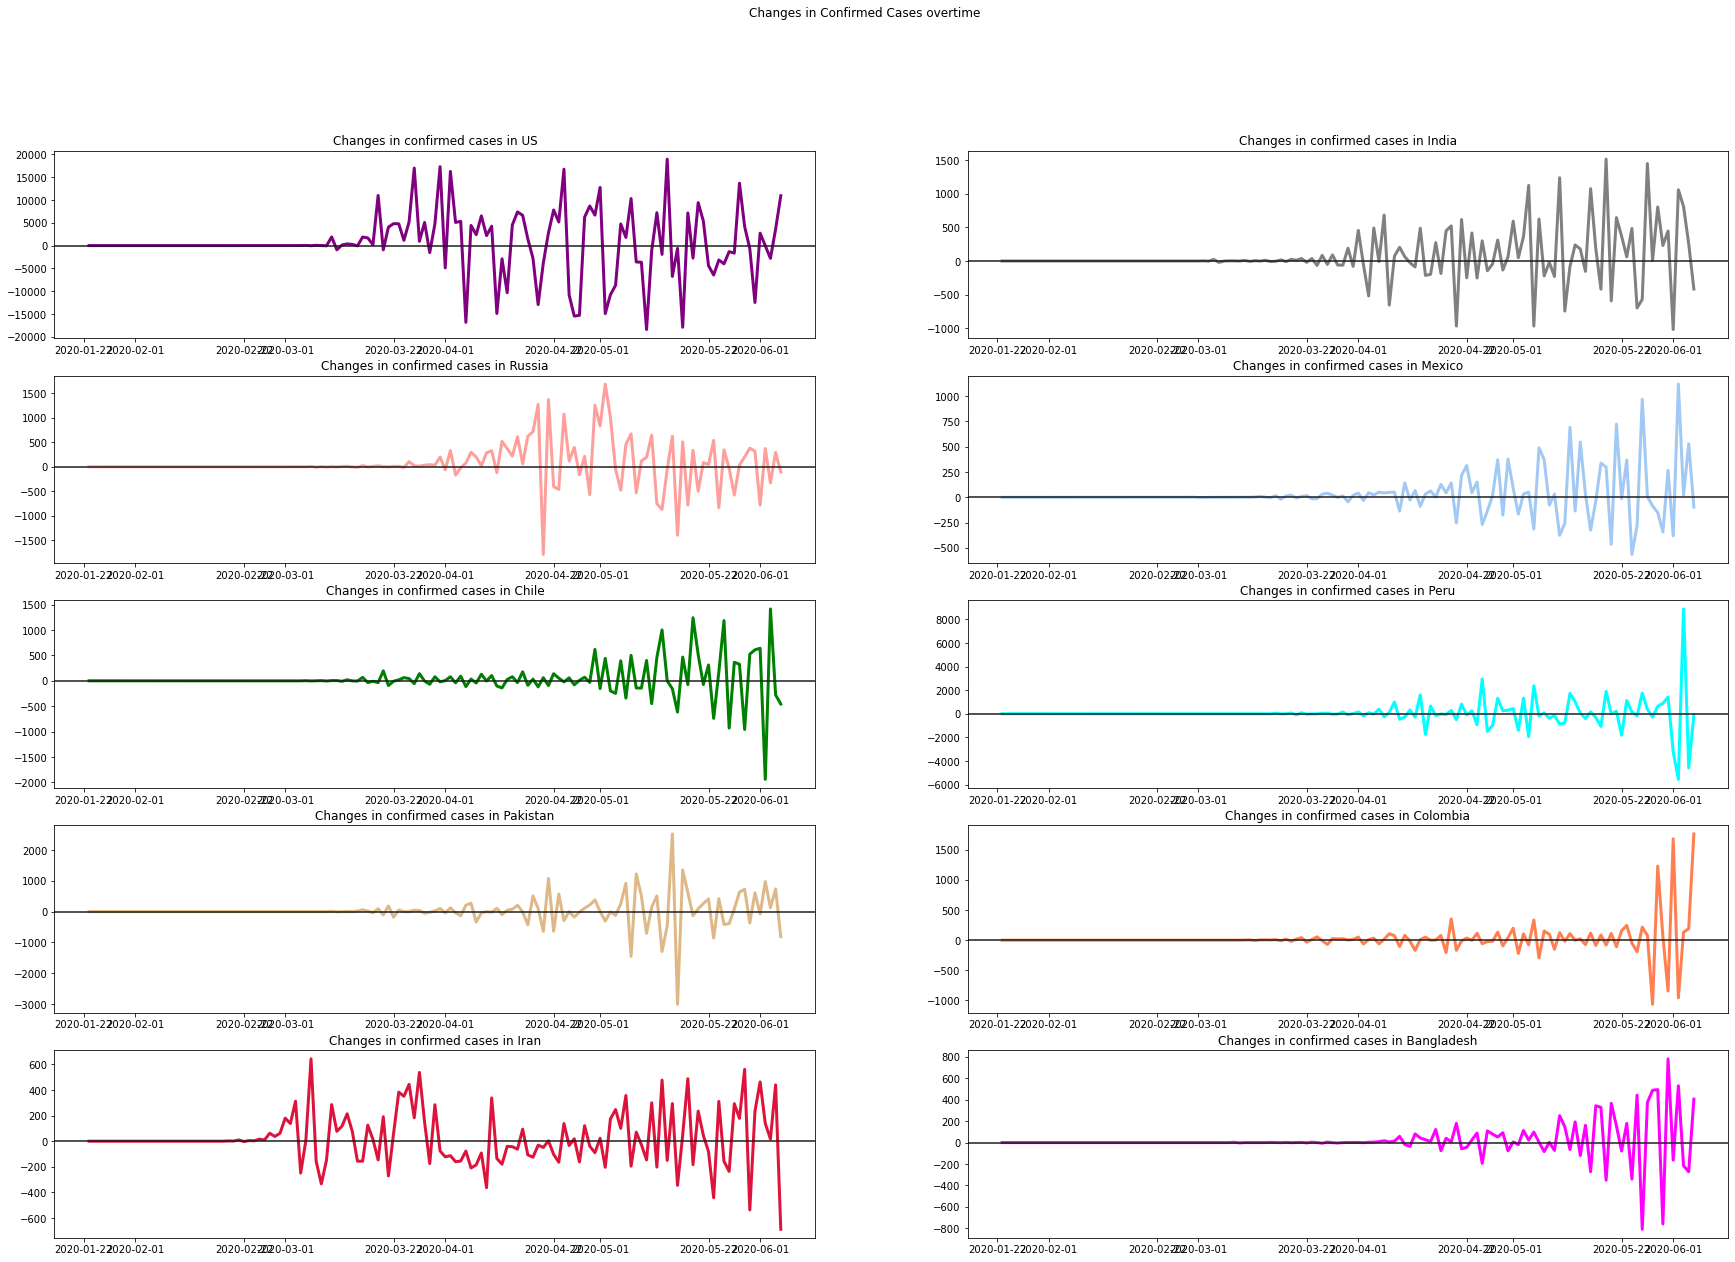

In [28]:
fig, ax = plt.subplots(5,2, figsize = (30, 20))

Graph_changes(cases_by_date, top10_cc.iloc[0],num_day = 3, ax = ax[0,0], color = 'purple')
Graph_changes(cases_by_date, top10_cc.iloc[1],num_day = 3, ax = ax[0,1], color = 'grey')
Graph_changes(cases_by_date, top10_cc.iloc[2],num_day = 3, ax = ax[1,0], color = 'r')
Graph_changes(cases_by_date, top10_cc.iloc[3],num_day = 3, ax = ax[1,1], color = 'b')
Graph_changes(cases_by_date, top10_cc.iloc[4],num_day = 3, ax = ax[2,0], color = 'green')
Graph_changes(cases_by_date, top10_cc.iloc[5],num_day = 3, ax = ax[2,1], color = 'cyan')
Graph_changes(cases_by_date, top10_cc.iloc[6],num_day = 3, ax = ax[3,0], color = 'burlywood')
Graph_changes(cases_by_date, top10_cc.iloc[7],num_day = 3, ax = ax[3,1], color = 'coral')
Graph_changes(cases_by_date, top10_cc.iloc[8],num_day = 3, ax = ax[4,0], color = 'crimson')
Graph_changes(cases_by_date, top10_cc.iloc[9],num_day = 3, ax = ax[4,1], color = 'magenta')

plt.suptitle('Changes in Confirmed Cases overtime')

In [29]:
## Fatalities from deaths_by_date

cases_fat_by_date = cases_by_date.merge(deaths_by_date[['Country_Region', 
                                             'Date', 'Fatalities']],
                             how = 'outer', on = ['Country_Region', 'Date'])
## Change type to datetime
cases_fat_by_date['Date'] = pd.to_datetime(cases_fat_by_date['Date'])

In [30]:
## Countries with decreasing number of cases in 6 consecutive days

## Only using data from May
may_covid = cases_fat_by_date[cases_fat_by_date['Date'] >= '2020-05-05']

## Get the names of the countries in descending order
sorted_cntries = may_covid.groupby(['Country_Region'], as_index = False).sum().sort_values(['ConfirmedCases'],
                                                                                              ascending = False)['Country_Region']
pattern = [True] * 6

cntr_ind = Find_pattern(may_covid, sorted_cntries, pattern)

recov_cntries = []

## Get the names 
for index in cntr_ind:
    country = cases_fat_by_date.iloc[index]['Country_Region']
    recov_cntries.append(country)
    
## Remove duplicates
recov_cntries = list(set(recov_cntries))
recov_cntries

C:\Users\qanh2\miniconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['Ghana',
 'Norway',
 'Algeria',
 'Tajikistan',
 'Saudi Arabia',
 'US',
 'Turkey',
 'Belgium']

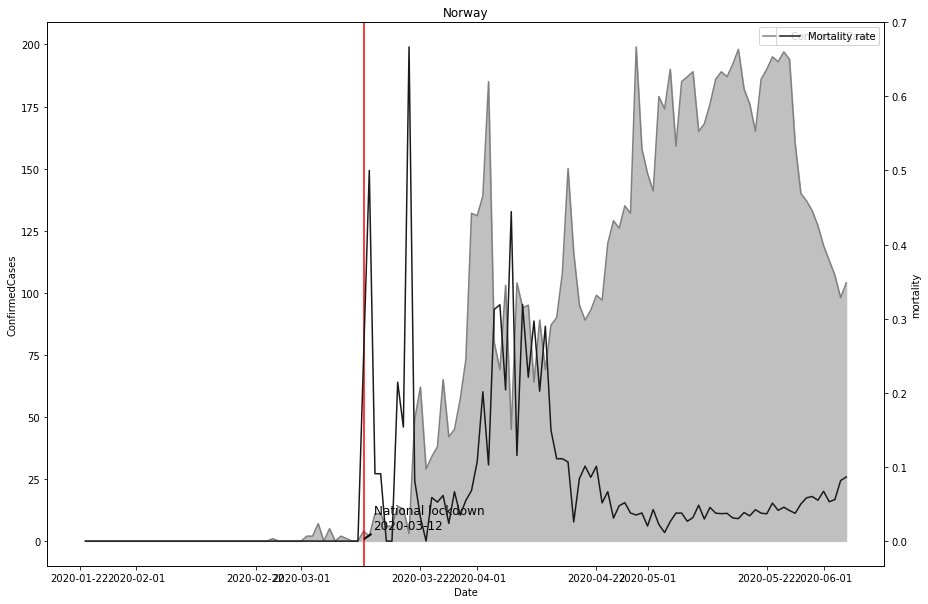

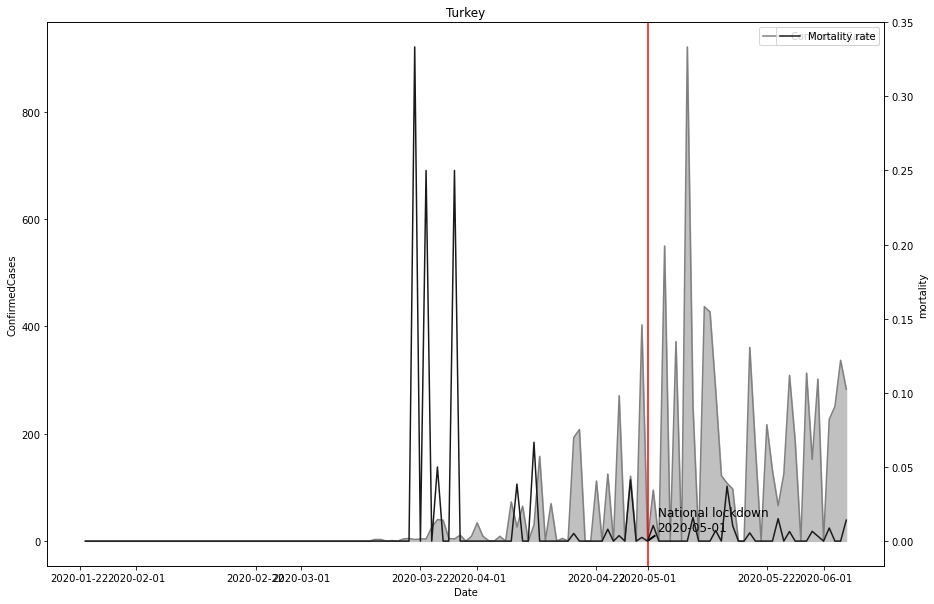

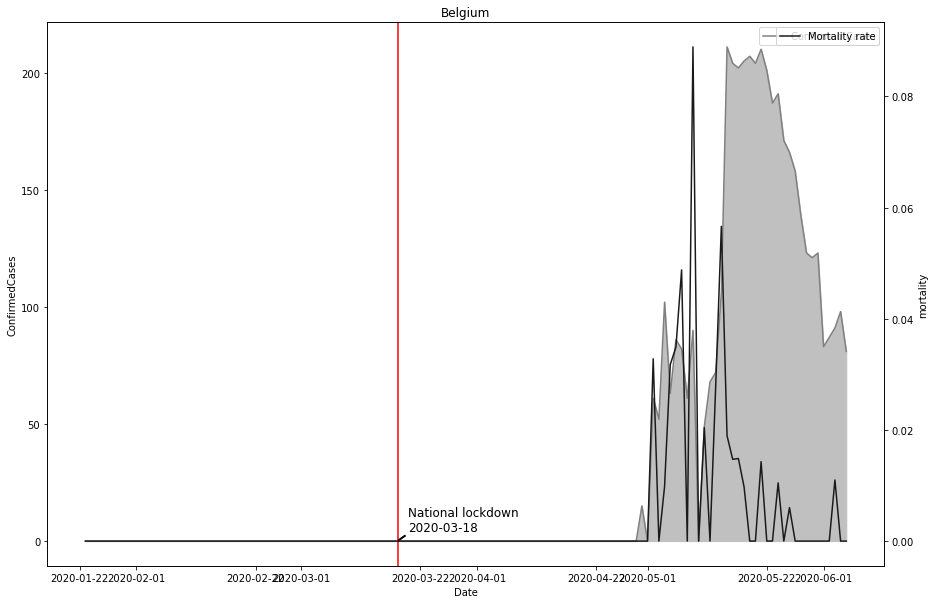

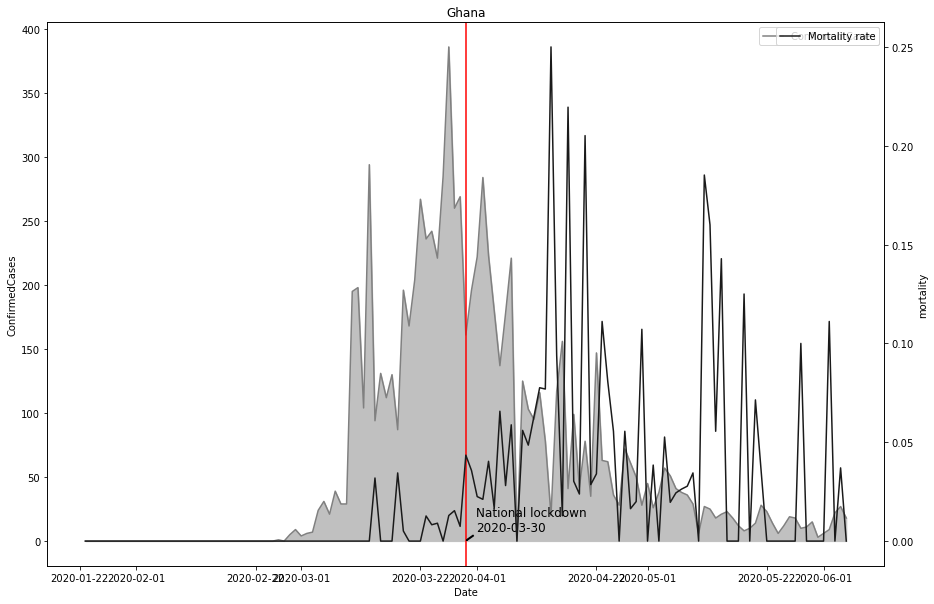

In [31]:
## Countries that are recovering

revcntry1 = cases_fat_by_date[cases_fat_by_date['Country_Region'] == recov_cntries[0]]
revcntry2 = cases_fat_by_date[cases_fat_by_date['Country_Region'] == recov_cntries[1]]
revcntry3 = cases_fat_by_date[cases_fat_by_date['Country_Region'] == recov_cntries[2]]
revcntry4 = cases_fat_by_date[cases_fat_by_date['Country_Region'] == recov_cntries[3]]

Graph_covid(revcntry3, 'Norway', '2020-03-12')
Graph_covid(revcntry1, 'Turkey', '2020-05-01')
Graph_covid(revcntry4, 'Belgium', '2020-03-18')
Graph_covid(revcntry2, 'Ghana', '2020-03-30')

In [32]:
## Get the coordinates

cases_fat_by_date_coords = cases_fat_by_date.merge(coords_analysis.drop(['population', 'Province_State'], axis = 1), how = 'outer', on = ['Country_Region'])
cases_fat_by_date_coords

Country_Region       Date      Id  Population    Weight  ConfirmedCases  \
0        Afghanistan 2020-01-23       1    27657145  0.058359             0.0   
1        Afghanistan 2020-01-24       3    27657145  0.058359             0.0   
2        Afghanistan 2020-01-25       5    27657145  0.058359             0.0   
3        Afghanistan 2020-01-26       7    27657145  0.058359             0.0   
4        Afghanistan 2020-01-27       9    27657145  0.058359             0.0   
...              ...        ...     ...         ...       ...             ...   
43195       Zimbabwe 2020-06-01  969621    14240168  0.060711            25.0   
43196       Zimbabwe 2020-06-02  969623    14240168  0.060711             3.0   
43197       Zimbabwe 2020-06-03  969625    14240168  0.060711            16.0   
43198       Zimbabwe 2020-06-04  969627    14240168  0.060711            15.0   
43199       Zimbabwe 2020-06-05  969629    14240168  0.060711            28.0   

       mortality  changes  Fatalities   lat   lon continent    area  density  
0            0.0      0.0         0.0  33.0  65.0      Asia  652230    58.33  
1            0.0      0.0         0.0  33.0  65.0      Asia  652230    58.33  
2            0.0      0.0         0.0  33.0  65.0      Asia  652230    58.33  
3            0.0      0.0         0.0  33.0  65.0      Asia  652230    58.33  
4            0.0      0.0         0.0  33.0  65.0      Asia  652230    58.33  
...          ...      ...         ...   ...   ...       ...     ...      ...  
43195        0.0     21.0         0.0 -20.0  30.0    Africa  390757    37.48  
43196        0.0    -22.0         0.0 -20.0  30.0    Africa  390757    37.48  
43197        0.0     13.0         0.0 -20.0  30.0    Africa  390757    37.48  
43198        0.0     -1.0         0.0 -20.0  30.0    Africa  390757    37.48  
43199        0.0     13.0         0.0 -20.0  30.0    Africa  390757    37.48  

[43200 rows x 14 columns]

In [33]:
## Check for any mismatches in country names

set(testing_worldwide_analysis['Country_Region']) - set(cases_fat_by_date_coords['Country_Region'])

{'Czech Republic',
 'DR Congo',
 'Democratic Republic of the Congo',
 'Emilia-Romagna',
 'Ivory Coast',
 'Liguria',
 'Lombardy',
 'Marche',
 'Myanmar',
 'North Korea',
 'Northern Cyprus',
 'Palestine',
 'Piedmont',
 'Scotland',
 'South Korea',
 'Taiwan',
 'Tuscany',
 'United States',
 'Veneto'}

In [34]:
## Resolve naming issues

testing_worldwide_analysis['Country_Region'].replace(['United States', 'South Korea', 'Democratic Republic of the Congo', 'Taiwan'],
                                 ['US', 'Korea, South', 'Congo (Brazzaville)', 'Taiwan*'], inplace = True)
testing_worldwide_analysis['Date'] = pd.to_datetime(testing_worldwide_analysis['Date'])

new_testing = testing_worldwide_analysis[['Date', 'Country_Region', 'positive',
                      'hospitalizedCurr', 'recovered', 'total_tested']]

In [35]:
## Testing info
testing_by_date = cases_fat_by_date_coords.merge(new_testing, how = 'left', on = ['Country_Region', 'Date'])

## Fill in NAs with 0
testing_by_date.fillna(0, inplace = True)
testing_by_date.head()

Country_Region       Date  Id  Population    Weight  ConfirmedCases  \
0    Afghanistan 2020-01-23   1    27657145  0.058359             0.0   
1    Afghanistan 2020-01-24   3    27657145  0.058359             0.0   
2    Afghanistan 2020-01-25   5    27657145  0.058359             0.0   
3    Afghanistan 2020-01-26   7    27657145  0.058359             0.0   
4    Afghanistan 2020-01-27   9    27657145  0.058359             0.0   

   mortality  changes  Fatalities   lat   lon continent    area  density  \
0        0.0      0.0         0.0  33.0  65.0      Asia  652230    58.33   
1        0.0      0.0         0.0  33.0  65.0      Asia  652230    58.33   
2        0.0      0.0         0.0  33.0  65.0      Asia  652230    58.33   
3        0.0      0.0         0.0  33.0  65.0      Asia  652230    58.33   
4        0.0      0.0         0.0  33.0  65.0      Asia  652230    58.33   

   positive  hospitalizedCurr  recovered  total_tested  
0       0.0               0.0        0.0           0.0  
1       0.0               0.0        0.0           0.0  
2       0.0               0.0        0.0           0.0  
3       0.0               0.0        0.0           0.0  
4       0.0               0.0        0.0           0.0

(<matplotlib.axes._subplots.AxesSubplot at 0x2128b1149c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2128adc8bc8>)

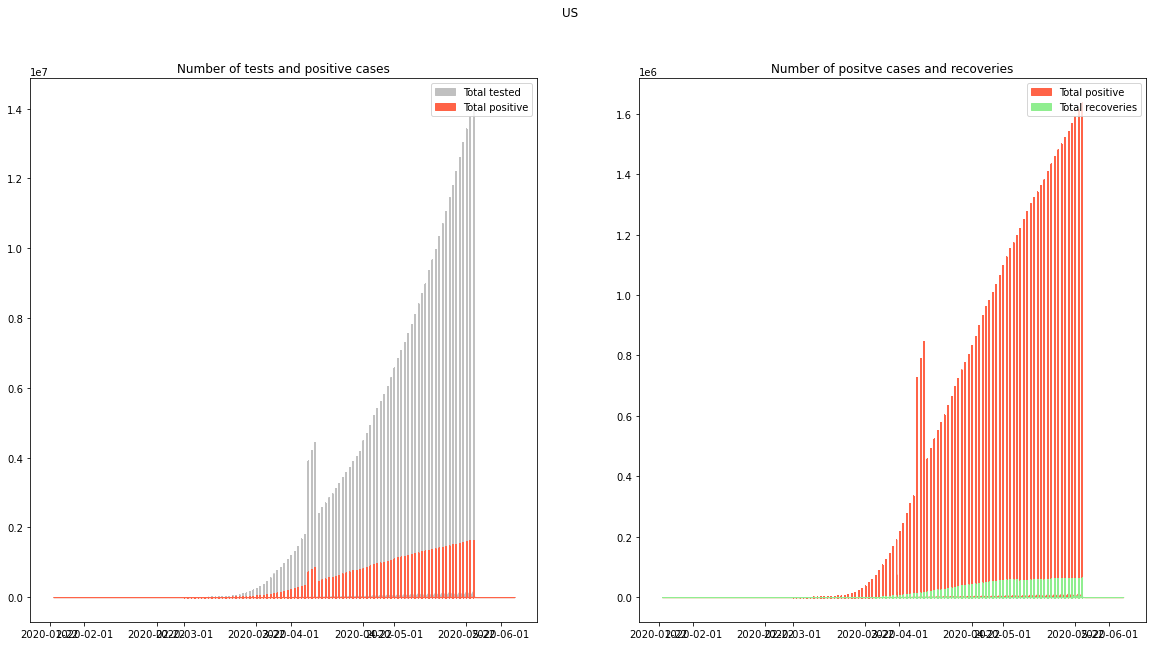

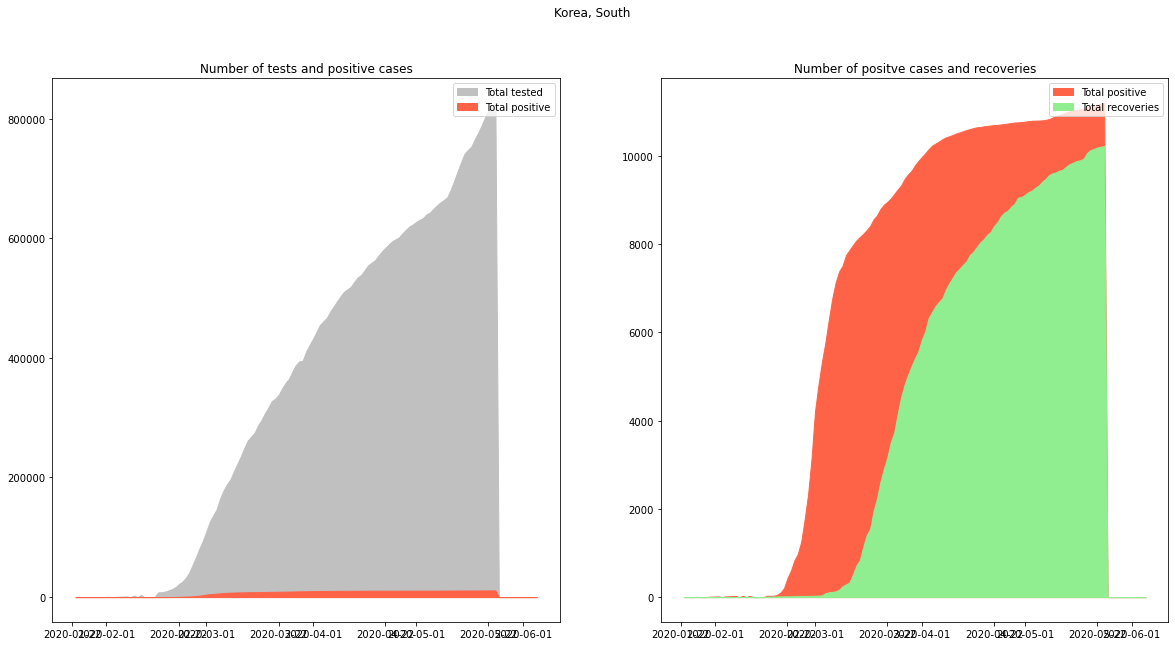

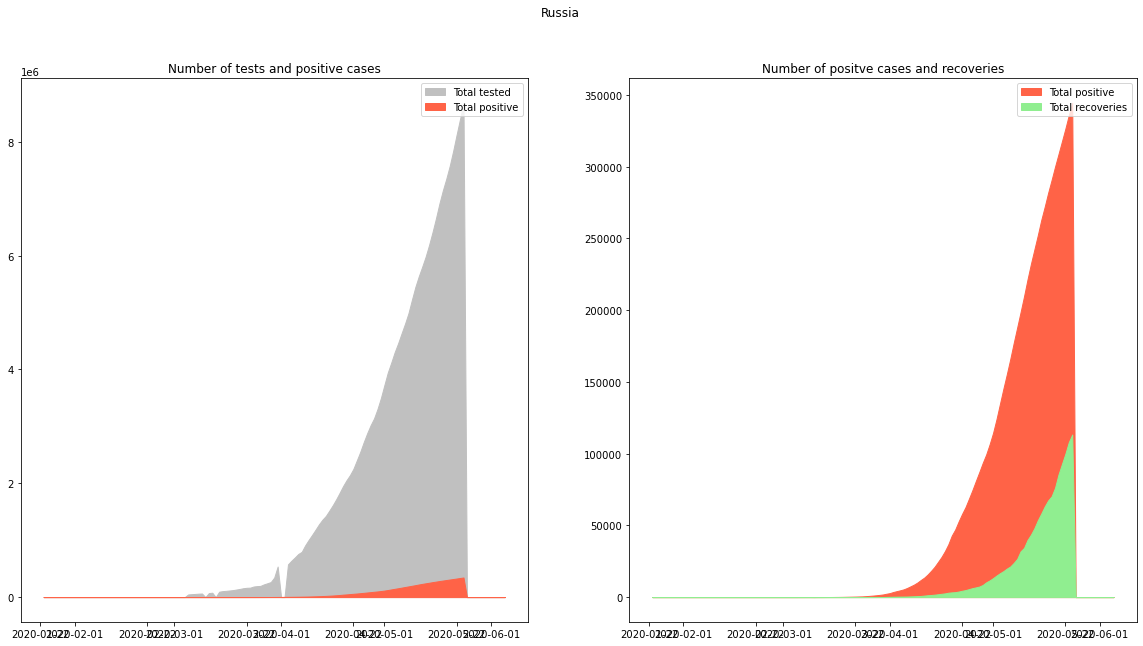

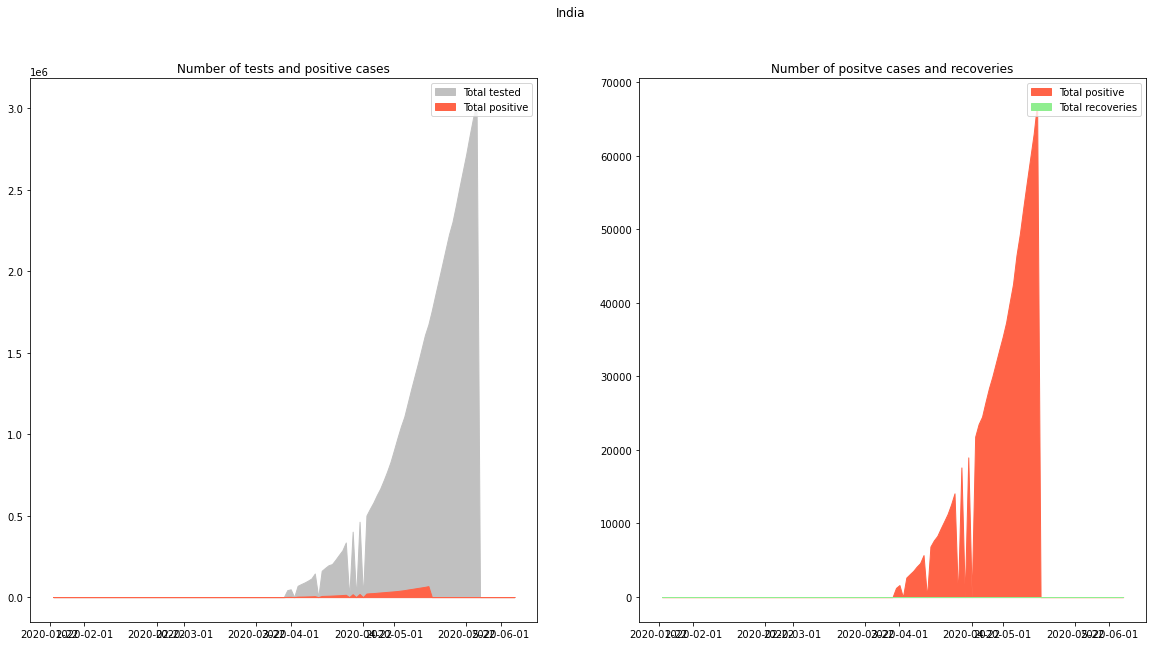

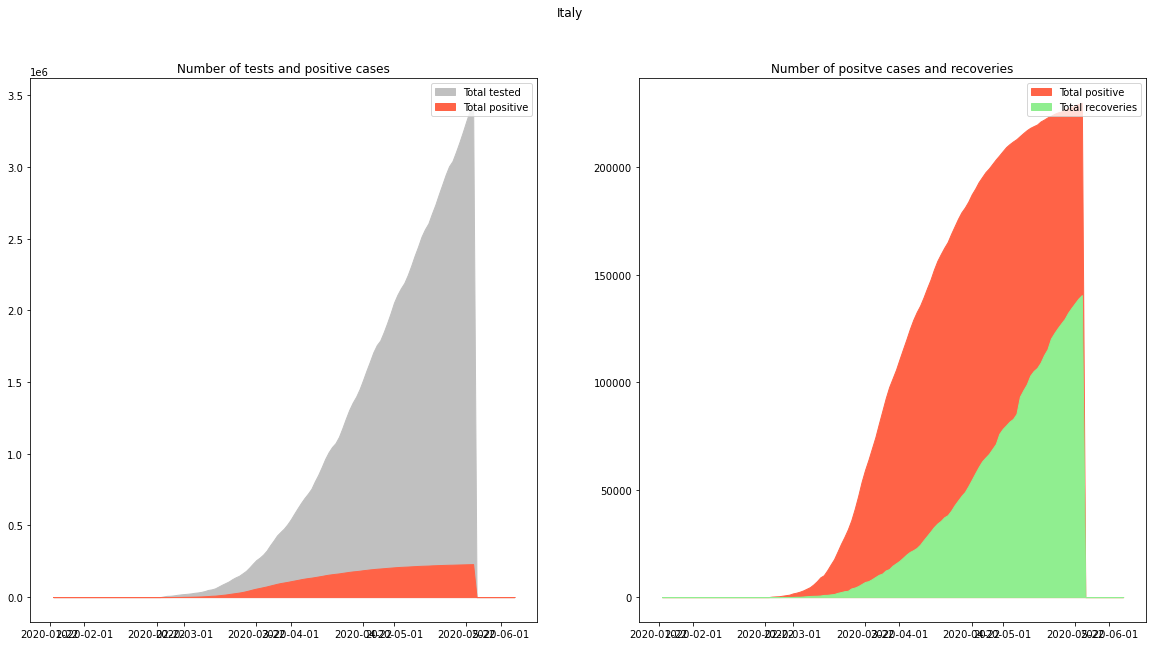

In [36]:
Graph_testing_data(testing_by_date, 'US')
Graph_testing_data(testing_by_date, 'Korea, South')
Graph_testing_data(testing_by_date, 'Russia')
Graph_testing_data(testing_by_date, 'India')
Graph_testing_data(testing_by_date, 'Italy')

In [37]:
## A Dataframe to store aggregated confirmed cases and number of people tested

gb = testing_by_date[['Country_Region', 'Population', 'total_tested', 'ConfirmedCases']]
gb = gb.groupby(['Country_Region']).agg(\
                                       Population = ('Population', 'mean'),
                                       total_tested = ('total_tested', 'sum'),
                                       ConfirmedCases = ('ConfirmedCases', 'sum'))
gb['% population tested'] = gb['total_tested'] / gb['Population'] * 100
gb['% population infected'] = gb['ConfirmedCases'] / gb['Population'] * 100

## Sort by the tested population and confirmed cases
gb.sort_values(['% population tested', '% population infected'], ascending = False, inplace = True)

## Remove the US
gb.drop(['US'], axis = 0, inplace = True)

[Text(0, 0.5, '% population tested'),
 Text(0.5, 0, 'Country'),
 Text(0.5, 1.0, 'Percent of population infected vs. testing population in countries with lowest Covid19 testing populations')]

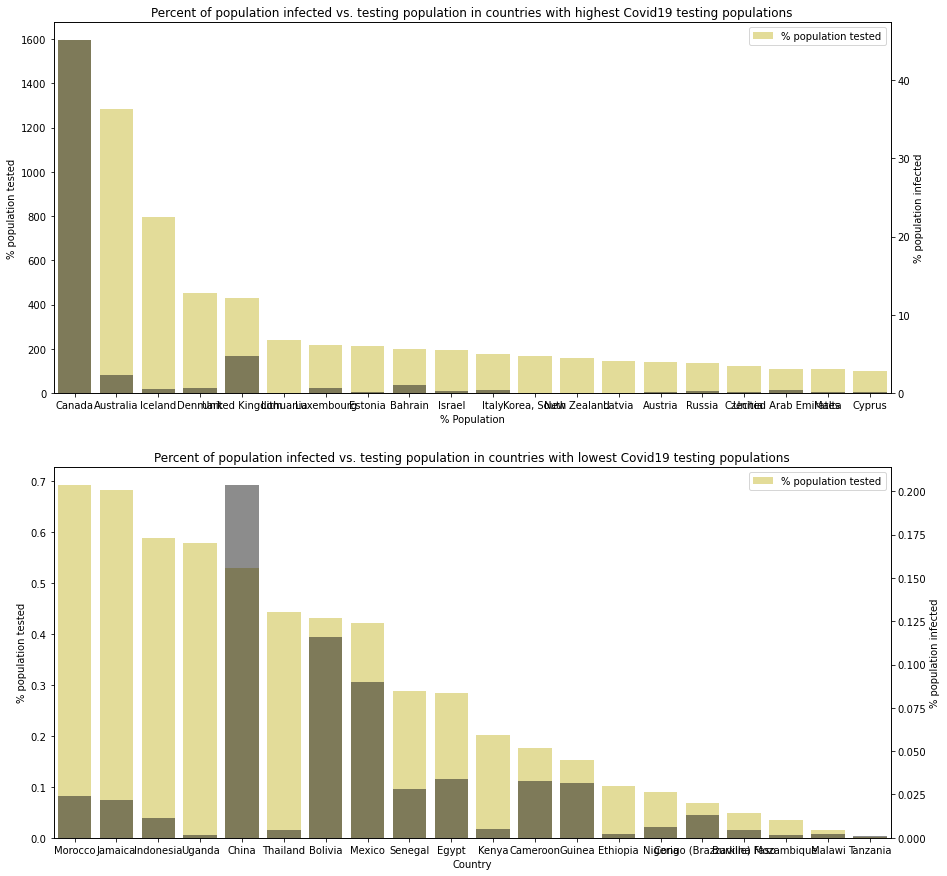

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15,15))


## Countries with high testing populations
sns.set_color_codes("muted")
sns.barplot(y = "% population tested", x = gb[:20].index, data = gb[:20], color = 'khaki', 
            label = '% population tested', ax = ax1)

ax1_dual = ax1.twinx()

sns.set_color_codes("pastel")
sns.barplot(y = '% population infected', x = gb[:20].index, data = gb[:20], color = 'k',
                  label = '% population infected', ax = ax1_dual, alpha = 0.5)

ax1.legend(ncol=2, loc="upper right", frameon=True)
ax1.set(ylabel='% population tested',
       xlabel="% Population", title = 'Percent of population infected vs. testing population in countries with highest Covid19 testing populations')


## Countries with lower testing populations 

low_20 = gb[(gb['ConfirmedCases'] != 0) & (gb['total_tested'] != 0)][-20:]

sns.set_color_codes("muted")
sns.barplot(y = "% population tested", x = low_20.index, 
            data = low_20, color = 'khaki', 
            label = '% population tested', ax = ax2)

ax2_dual = ax2.twinx()

sns.set_color_codes("pastel")
sns.barplot(y = '% population infected', x = low_20.index,
                data = low_20, color = 'k', ax = ax2_dual, alpha = 0.5)

ax2.legend(ncol=2, loc="upper right", frameon=True)
ax2.set(ylabel="% population tested",
       xlabel='Country', title = 'Percent of population infected vs. testing population in countries with lowest Covid19 testing populations')

In [39]:
# ## Resolve comma issue later on
# testing_by_date['Country_Region'].replace('Korea, South', 'South Korea', inplace = True)

spread = {}

## Date on which the first case of covid was detected in each country
for i in testing_by_date['Country_Region'].unique():
    
    df = testing_by_date[(testing_by_date['Country_Region'] == i) & testing_by_date['ConfirmedCases'] != 0]
    start_date = df['Date'].min()
    
    if start_date in spread:
        spread[start_date] = spread.get(start_date) + ',' + i
    else:
        spread[start_date] = i

In [40]:
## Sort by date

sorted_spread = sorted(spread.items(), key = lambda kv:(kv[0],kv[1]))
sorted_spread

[(Timestamp('2020-01-23 00:00:00'), 'China,Singapore,Thailand,Vietnam'),
 (Timestamp('2020-01-24 00:00:00'), 'France,Korea, South,Taiwan*,US'),
 (Timestamp('2020-01-25 00:00:00'), 'Malaysia,Nepal'),
 (Timestamp('2020-01-26 00:00:00'), 'Australia,Canada,Japan'),
 (Timestamp('2020-01-27 00:00:00'), 'Cambodia,Germany,Sri Lanka'),
 (Timestamp('2020-01-29 00:00:00'), 'Finland,United Arab Emirates'),
 (Timestamp('2020-01-30 00:00:00'), 'India,Philippines'),
 (Timestamp('2020-01-31 00:00:00'), 'Italy,Russia,Sweden,United Kingdom'),
 (Timestamp('2020-02-01 00:00:00'), 'Spain'),
 (Timestamp('2020-02-04 00:00:00'), 'Belgium'),
 (Timestamp('2020-02-07 00:00:00'), 'Diamond Princess'),
 (Timestamp('2020-02-14 00:00:00'), 'Egypt'),
 (Timestamp('2020-02-19 00:00:00'), 'Iran'),
 (Timestamp('2020-02-21 00:00:00'), 'Israel,Lebanon'),
 (Timestamp('2020-02-24 00:00:00'), 'Afghanistan,Bahrain,Iraq,Kuwait,Oman'),
 (Timestamp('2020-02-25 00:00:00'), 'Algeria,Austria,Croatia,Switzerland'),
 (Timestamp('2020-0

In [41]:
dates = []
num_cntries = []
cntries = []

for n in sorted_spread:
        
        ## Collect the dates
        dates.append(n[0])
        ## Names of Countries infected
        cntries.append(n[1])
        ## Number of countries infected
        num_cntries.append(len(n[1].split(',')))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]),
 <a list of 55 Text major ticklabel objects>)

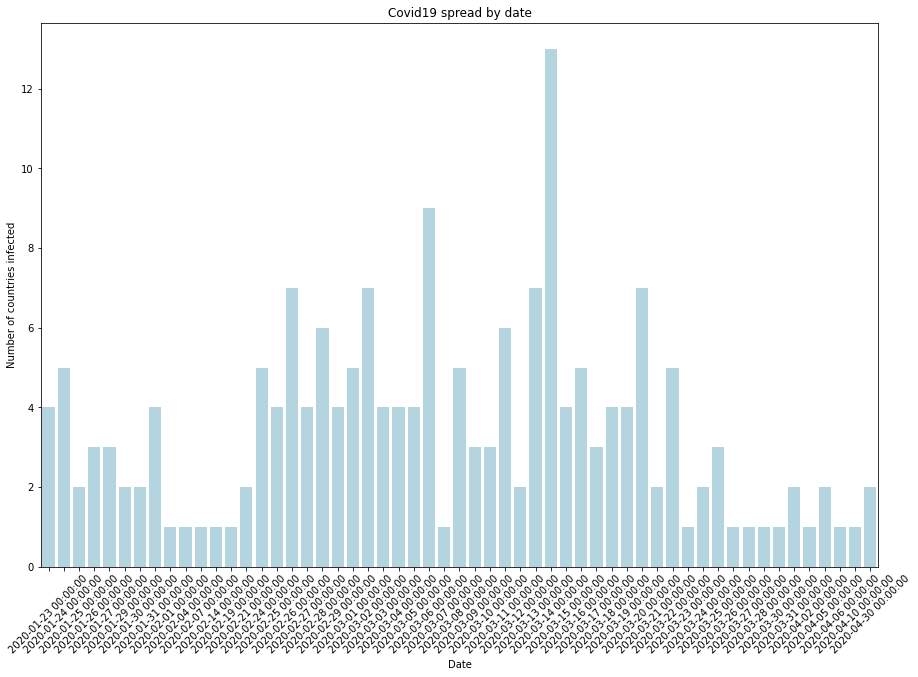

In [42]:
plt.figure(figsize = (15, 10))

ax = sns.barplot(x = dates, y = num_cntries, color = 'lightblue')
ax.set(xlabel = 'Date', ylabel = 'Number of countries infected', title = 'Covid19 spread by date')
plt.xticks(rotation = 45)

In [43]:
map_data = []
for date in cases_fat_by_date_coords.Date.sort_values().unique():
    map_data.append(cases_fat_by_date_coords.loc[cases_fat_by_date_coords.Date == date, ['lat', 'lon', 'ConfirmedCases']]\
                    .groupby(['lat', 'lon']).sum().reset_index().values.tolist())

In [44]:
base_map = folium.Map(zoom_start=4,tiles='openstreetmap')
HeatMapWithTime(map_data, radius=5, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

# 2. Modelling

In [45]:
# Reading Train, Test, lockdown and submission datasets 
df_test = pd.read_csv("../data/week5/test.csv")
df_train = pd.read_csv("../data/week5/train.csv")
df_sub = pd.read_csv("../data/week5/submission.csv")
lockdown = pd.read_csv('../data/week4/countryLockdowndates.csv')

In [46]:
valid_date = df_test.Date.min()
valid_date

'2020-04-27'

In [47]:
# Seperating train and test data by clearing the overlapping points.

df_train = df_train[df_train.Date < valid_date]
df = pd.concat([df_train, df_test])
df.Date = pd.to_datetime(df.Date)

In [48]:
print(df_train.Date.max())
print(df_test.Date.max())

2020-04-26
2020-06-10


In [49]:
from sklearn.preprocessing import LabelEncoder
from datetime import datetime

# Making geography column by joining Country_Region + Province_state + County

df["geography"] = df.Country_Region + "_" + df.Province_State + "_" + df.County # Country_Region + Province_state + County

df.loc[df.County.isna(), "geography"] = df[df.County.isna()].Country_Region + "_" + df[df.County.isna()].Province_State # Country_Region + Province_state + NA

df.loc[df.Province_State.isna(), "geography"] = df[df.Province_State.isna()].Country_Region # Country_Region + NA + NA

df.loc[(df.TargetValue < 0 ),'TargetValue']=0

df["_TargetValue"] = df["TargetValue"]

In [50]:
#merge lockdown

lockdown['Date'] = pd.to_datetime(lockdown['Date'], format = '%d/%m/%Y')
def get_lockdown(row):
    ld = lockdown[ (lockdown['Country/Region'] == row['Country_Region']) & (lockdown['Province'] == row['Province_State']) ]
    
    if(len(ld.index) > 0):
        if( row['Date'] >= ld.iloc[0]['Date'] ):
            return ld.iloc[0]['Type']
    return np.nan
    
df['lockdown'] = df.apply(get_lockdown, axis=1)
df['lockdown'] = df['lockdown'].fillna('None')

In [51]:
df['lockdown'].unique()

array(['None', 'Full', 'Partial'], dtype=object)

In [52]:
#Label Encoding Country_Region, Province_State, County, Target
le_Country_Region = LabelEncoder()
df['Country_Region'] = le_Country_Region.fit_transform(df.Country_Region.astype(str))

le_Province_State = LabelEncoder()
df['Province_State'] = le_Province_State.fit_transform(df.Province_State.astype(str))

le_County = LabelEncoder()
df['County'] = le_County.fit_transform(df.County.astype(str))

le_Target = LabelEncoder()
df['Target'] = le_Target.fit_transform(df.Target.astype(str))

le_lockdown = LabelEncoder()
df['lockdown'] = le_lockdown.fit_transform(df.lockdown.astype(str))

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969640 entries, 0 to 311669
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Id              657970 non-null  float64       
 1   County          969640 non-null  int32         
 2   Province_State  969640 non-null  int32         
 3   Country_Region  969640 non-null  int32         
 4   Population      969640 non-null  int64         
 5   Weight          969640 non-null  float64       
 6   Date            969640 non-null  datetime64[ns]
 7   Target          969640 non-null  int32         
 8   TargetValue     657970 non-null  float64       
 9   ForecastId      311670 non-null  float64       
 10  geography       969640 non-null  object        
 11  _TargetValue    657970 non-null  float64       
 12  lockdown        969640 non-null  int32         
dtypes: datetime64[ns](1), float64(5), int32(5), int64(1), object(1)
memory usage: 85.1+ MB


In [54]:
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9]
lag_cols = [f"lag_{lag}" for lag in lags]

wins = [3,7]
lag_wins = [1,2,3]

win_cols = []
for win in wins:
    for lag_win in lag_wins:
        win_col = f"rmean_{lag_win}_{win}"  
        win_cols = win_cols + [win_col]

# This function creates lag features and Window features to be fed into the model.
def createfeature(df):   
    df.sort_values(["geography", "Date", "Target"], inplace = True)
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df.groupby(["geography", "Target"])["TargetValue"].shift(lag)

    for win in wins:
        for lag_win in lag_wins:
            win_col = f"rmean_{lag_win}_{win}"          
            df[win_col] = df[[f"lag_{lag}" for lag in range(lag_win, lag_win+win)]].mean(axis = 1)

    return df
    

In [55]:
df = createfeature(df)

In [57]:
#df.to_csv("df.csv", index = False)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 969640 entries, 0 to 311669
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Id              657970 non-null  float64       
 1   County          969640 non-null  int32         
 2   Province_State  969640 non-null  int32         
 3   Country_Region  969640 non-null  int32         
 4   Population      969640 non-null  int64         
 5   Weight          969640 non-null  float64       
 6   Date            969640 non-null  datetime64[ns]
 7   Target          969640 non-null  int32         
 8   TargetValue     657970 non-null  float64       
 9   ForecastId      311670 non-null  float64       
 10  geography       969640 non-null  object        
 11  _TargetValue    657970 non-null  float64       
 12  lockdown        969640 non-null  int32         
 13  lag_1           657970 non-null  float64       
 14  lag_2           657970 non-null  flo

In [59]:
df

Id  County  Province_State  Country_Region  Population    Weight  \
0       1.0    1840             133               0    27657145  0.058359   
1       2.0    1840             133               0    27657145  0.583587   
2       3.0    1840             133               0    27657145  0.058359   
3       4.0    1840             133               0    27657145  0.583587   
4       5.0    1840             133               0    27657145  0.058359   
...     ...     ...             ...             ...         ...       ...   
311665  NaN    1840             133             186    14240168  0.607106   
311666  NaN    1840             133             186    14240168  0.060711   
311667  NaN    1840             133             186    14240168  0.607106   
311668  NaN    1840             133             186    14240168  0.060711   
311669  NaN    1840             133             186    14240168  0.607106   

             Date  Target  TargetValue  ForecastId  ... lag_6  lag_7  lag_8  \
0      2020-01-23       0          0.0         NaN  ...   NaN    NaN    NaN   
1      2020-01-23       1          0.0         NaN  ...   NaN    NaN    NaN   
2      2020-01-24       0          0.0         NaN  ...   NaN    NaN    NaN   
3      2020-01-24       1          0.0         NaN  ...   NaN    NaN    NaN   
4      2020-01-25       0          0.0         NaN  ...   NaN    NaN    NaN   
...           ...     ...          ...         ...  ...   ...    ...    ...   
311665 2020-06-08       1          NaN    311666.0  ...   NaN    NaN    NaN   
311666 2020-06-09       0          NaN    311667.0  ...   NaN    NaN    NaN   
311667 2020-06-09       1          NaN    311668.0  ...   NaN    NaN    NaN   
311668 2020-06-10       0          NaN    311669.0  ...   NaN    NaN    NaN   
311669 2020-06-10       1          NaN    311670.0  ...   NaN    NaN    NaN   

        lag_9  rmean_1_3  rmean_2_3  rmean_3_3  rmean_1_7  rmean_2_7  \
0         NaN        NaN        NaN        NaN        NaN        NaN   
1         NaN        NaN        NaN        NaN        NaN        NaN   
2         NaN        0.0        NaN        NaN        0.0        NaN   
3         NaN        0.0        NaN        NaN        0.0        NaN   
4         NaN        0.0        0.0        NaN        0.0        0.0   
...       ...        ...        ...        ...        ...        ...   
311665    NaN        NaN        NaN        NaN        NaN        NaN   
311666    NaN        NaN        NaN        NaN        NaN        NaN   
311667    NaN        NaN        NaN        NaN        NaN        NaN   
311668    NaN        NaN        NaN        NaN        NaN        NaN   
311669    NaN        NaN        NaN        NaN        NaN        NaN   

        rmean_3_7  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
...           ...  
311665        NaN  
311666        NaN  
311667        NaN  
311668        NaN  
311669        NaN  

[969640 rows x 28 columns]

In [60]:
df.shape

(969640, 28)

In [61]:
# Creating Features (lag and win features + given so called features)

features = ["Country_Region", "Province_State", "County", "Population","Target", "Weight", "lockdown"] + lag_cols + win_cols   
categorical_features = ["Country_Region", "Province_State", "County", "Target","lockdown"]


# Selecting only train data from 'df' as 'df' contains both train and test data concatenated together
# Spliting the training data into train and test splits

df_train = df[~(df.TargetValue.isna()) & ~ (df.lag_9.isna())]
X_train = df_train[df_train.Date < datetime(2020, 4, 20)][features]
y_train = df_train[df_train.Date < datetime(2020, 4, 20)].TargetValue.values
X_test = df_train[df_train.Date >= datetime(2020, 4, 20)][features]
y_test = df_train[df_train.Date >= datetime(2020, 4, 20)].TargetValue.values


# Printing the shape of test and train data

print(f"Train shape: {(X_train.shape, y_train.shape)}")
print(f"Test shape: {(X_test.shape, y_test.shape)}")


Train shape: ((547154, 22), (547154,))
Test shape: ((48482, 22), (48482,))


In [62]:
# Setting the quantiles to as asked

QUANTILE = [0.05, 0.5, 0.95]


# Calculating weighted pinball loss

def Weighted_Pinball_Loss(q, X_test, y_test, y_pred):
    df_weight = X_test[['Population','Target']].copy()
    df_weight['Weight'] = df_weight['Population']
    
    #Fatalities
    df_weight.loc[df_weight.Target == 1, 'Weight'] = 10 *  df_weight.loc[df_weight.Target == 1, 'Weight']
    #W = X_test.apply(lambda x: x.Population if x.Target == 0 else 10 * x.Population, axis=1).values
    W = df_weight['Weight'].values
    W = np.log(W+1) ** -1
    e = y_test - y_pred
    L = np.maximum(q * e, (q - 1) * e)
    score = np.average(L, weights = W)
    return score



In [63]:
def quantile_loss(q,y_true,y_pred):
    e = y_true - y_pred
    return np.maximum(q * e, (q - 1) * e).mean()

# 2.1 Gradient Boosting Regressor

In [64]:
%%time

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

LEARNING_RATE = 0.01
#N_ESTIMATORS = 2000
N_ESTIMATORS = 1000

model_bst_save = {}
score_bst_save = {}
mse_bst_save = {}

for alpha in QUANTILE:
    print(f'Train quantile: {alpha}')
    model = GradientBoostingRegressor(loss='quantile', alpha=alpha, n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE, n_iter_no_change = 10, validation_fraction = 0.2)
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(f' Number estimator: {model.n_estimators_}')
    n_est_build = model.n_estimators_
    model = GradientBoostingRegressor(loss='quantile', alpha=alpha, n_estimators=n_est_build, learning_rate=LEARNING_RATE)
    score = Weighted_Pinball_Loss(alpha,X_test,y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    score_bst_save.update({alpha: score})
    mse_bst_save.update({alpha: mse})
    print(f' Weighted Pinball Loss {score}')
    print(f' MSE {mse}')
    model = model.fit(df_train[features], df_train.TargetValue.values)
    model_bst_save.update({alpha: model})

print(f'Average Pinball Loss: {np.mean(list(score_bst_save.values()))}')
print(f'Average MSE: {np.mean(list(mse_bst_save.values()))}')

model_bst_reg = GradientBoostingRegressor(loss='ls',n_estimators=N_ESTIMATORS, learning_rate=LEARNING_RATE, n_iter_no_change = 10, validation_fraction = 0.2)
model_bst_save.update({'reg': model_bst_reg})

Train quantile: 0.05
 Number estimator: 11
 Weighted Pinball Loss 0.7570529259754246
 MSE 163842.31199207954
Train quantile: 0.5
 Number estimator: 537
 Weighted Pinball Loss 4.080755904978307
 MSE 123145.07791448872
Train quantile: 0.95
 Number estimator: 476
 Weighted Pinball Loss 1.3247739980935829
 MSE 18709.46797234833
Average Pinball Loss: 2.054194276349105
Average MSE: 101898.95262630553
Wall time: 32min 9s


# 2.2 XGBoost Regressor

In [65]:
%%time

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost


N_ESTIMATORS = 1000

model_xgb_save = {}
score_xgb_save = {}
mse_xgb_save = {}

for alpha in QUANTILE:
    print(f'Train quantile: {alpha}')
    model = xgboost.XGBRegressor(n_estimators=N_ESTIMATORS,n_jobs=-1)
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
#     print(f' Number estimator: {model.n_estimators_}')
#     n_est_build = model.n_estimators_
#     model = xgboost.XGBRegressor(n_estimators=n_est_build,n_jobs=-1)
    score = Weighted_Pinball_Loss(alpha,X_test,y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    
    score_xgb_save.update({alpha: score})
    mse_xgb_save.update({ alpha:mse })
    print(f' Weighted Pinball Loss {score}')
    print(f' MSE {mse}')
    model = model.fit(df_train[features], df_train.TargetValue.values)
    model_xgb_save.update({alpha: model})

print(f'Average Pinball Loss: {np.mean(list(score_xgb_save.values()))}')
print(f'Average MSE: {np.mean(list(mse_xgb_save.values()))}')

# model_xgb_reg = XGBRegressor(loss='ls',n_estimators=1500, learning_rate=LEARNING_RATE, n_iter_no_change = 10, validation_fraction = 0.2)
# model_xgb_save.update({'reg': model_xgb_reg})

Train quantile: 0.05
[15:26:53] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 Weighted Pinball Loss 3.8440772373690866
 MSE 13837.421626590514
[15:28:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train quantile: 0.5
[15:30:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 Weighted Pinball Loss 3.1609884762976406
 MSE 13837.421626590514
[15:31:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train quantile: 0.95
[15:33:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
 Weighted Pinball Loss 2.4778997152261946
 MSE 13837.421626590514
[15:34:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Average Pinball Loss: 3.1609884762976406
Ave

# 2.3 Light GBM

In [66]:
%%time

import lightgbm as lgb

LEARNING_RATE = 0.1
N_ESTIMATORS = 2000
#N_ESTIMATORS = 1000

dtrain = lgb.Dataset(X_train, label = y_train, free_raw_data=False, categorical_feature = categorical_features)
dbuild = lgb.Dataset(df_train[features], label = df_train.TargetValue.values, free_raw_data=False, categorical_feature = categorical_features)
dval = lgb.Dataset(X_test, label = y_test, free_raw_data=False, categorical_feature = categorical_features)

model_lgb_save = {}
score_lgb_save = {}
mse_lgb_save = {}

for alpha in QUANTILE:
    params = {
        "objective": "quantile",
        #"objective": "regression",       
        "alpha": alpha,
        "learning_rate": LEARNING_RATE,
        "metric": "mse",
        "reg_sqrt": True
    }
       
    print(f'Train quantile: {alpha}')
    model_lgb_val = lgb.train(params, train_set = dtrain, valid_sets = [dval], num_boost_round = N_ESTIMATORS, early_stopping_rounds = 100, verbose_eval = 50)
    y_pred = model_lgb_val.predict(X_test)
    score = Weighted_Pinball_Loss(alpha,X_test,y_test,y_pred)
    mse = mean_squared_error(y_test,y_pred)
    
    score_lgb_save.update({alpha: score})
    mse_lgb_save.update({ alpha:mse })
    
    print(f' Weighted Pinball Loss {score}')
    print(f' MSE {mse}')
    
    model_lgb_build = lgb.train(params, train_set = dbuild, num_boost_round = model_lgb_val.best_iteration)
    model_lgb_save.update({alpha: model_lgb_build})

print(f'Average Pinball Loss: {np.mean(list(score_lgb_save.values()))}')
print(f'Average MSE: {np.mean(list(mse_lgb_save.values()))}')

# Create model to regresion forecast

params = {
    "objective": "regression",       
    "alpha": alpha,
    "learning_rate": LEARNING_RATE,
    "metric": "mse",
}

model_lgb_reg = lgb.train(params, train_set = dtrain, valid_sets = [dval], num_boost_round = N_ESTIMATORS, early_stopping_rounds = 100, verbose_eval = 50)
model_lgb_save.update({'reg': model_lgb_reg})

Train quantile: 0.05


C:\Users\qanh2\miniconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
[50]	valid_0's l2: 163803
[100]	valid_0's l2: 163802
[150]	valid_0's l2: 163802
[200]	valid_0's l2: 163802
[250]	valid_0's l2: 163802
[300]	valid_0's l2: 163802
[350]	valid_0's l2: 163802
Early stopping, best iteration is:
[264]	valid_0's l2: 163802
 Weighted Pinball Loss 0.7598430222727346
 MSE 163802.27888700963


C:\Users\qanh2\miniconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Train quantile: 0.5
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l2: 103466
[100]	valid_0's l2: 72251.4
[150]	valid_0's l2: 72251
Early stopping, best iteration is:
[73]	valid_0's l2: 72250
 Weighted Pinball Loss 3.455135292620821
 MSE 72250.0392010197


C:\Users\qanh2\miniconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Train quantile: 0.95
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l2: 25723.1
[100]	valid_0's l2: 27173.8
Early stopping, best iteration is:
[24]	valid_0's l2: 22065.6
 Weighted Pinball Loss 1.6255000449639825
 MSE 22065.563016904864


C:\Users\qanh2\miniconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Average Pinball Loss: 1.9468261199525128
Average MSE: 86039.29370164474
Training until validation scores don't improve for 100 rounds
[50]	valid_0's l2: 14830.5
[100]	valid_0's l2: 15588.9
[150]	valid_0's l2: 16170.1
Early stopping, best iteration is:
[56]	valid_0's l2: 14797.1
Wall time: 40.7 s


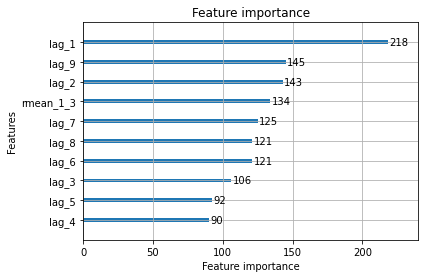

In [69]:
lgb.plot_importance(model_lgb_reg,max_num_features=10)

In [70]:
%%time

# LightGBM model
model_save = model_lgb_save
#model_save = model_bst_save


# Predict by day

df_sub = pd.DataFrame()
for pred_date in df_test.Date.unique():
    print(f'Predict day {pred_date}')
    X_pred = df[df.Date == pred_date][features]
    if isinstance(model_save,dict):
        for alpha in QUANTILE:
            Y_pred = model_save[alpha].predict(X_pred)
            df_sub = df_sub.append(pd.DataFrame({
                'ForecastId': (df_test[df_test.Date == pred_date]['ForecastId']).values,
                'Quantile': alpha,
                'ForecastId_Quantile': (df_test[df_test.Date == pred_date]['ForecastId'].astype(str) + '_' + str(alpha)).values, 
                'TargetValue': Y_pred }),ignore_index=True)
            # Save target with accuracy forecast
            #if alpha == 0.5:
            #    df.loc[df.Date == pred_date, 'TargetValue'] = Y_pred
            #    df = createfeature(df)
        # Predict new target
        Y_pred = model_save['reg'].predict(X_pred)
        df.loc[df.Date == pred_date, 'TargetValue'] = Y_pred
        df = createfeature(df)
    else: #Random Forest
        rf_preds = []
        for estimator in model_save.estimators_:
            rf_preds.append(estimator.predict(X_pred))
        rf_preds = np.array(rf_preds).transpose()

        for alpha in QUANTILE:
            y_pred = np.percentile(rf_preds, alpha * 100, axis=1)
            df_sub = df_sub.append(pd.DataFrame({
                'ForecastId': (df_test[df_test.Date == pred_date]['ForecastId']).values,
                'Quantile': alpha,
                'ForecastId_Quantile': (df_test[df_test.Date == pred_date]['ForecastId'].astype(str) + '_' + str(alpha)).values, 
                'TargetValue': Y_pred }),ignore_index=True)
        y_pred = model_save.predict(X_pred)
        df.loc[df.Date == pred_date, 'TargetValue'] = y_pred
        df = createfeature(df)           
        
    # Create submission
df_sub = df_sub.sort_values(['ForecastId','Quantile']).reset_index(drop = True)

Predict day 2020-04-27
Predict day 2020-04-28
Predict day 2020-04-29
Predict day 2020-04-30
Predict day 2020-05-01
Predict day 2020-05-02
Predict day 2020-05-03
Predict day 2020-05-04
Predict day 2020-05-05
Predict day 2020-05-06
Predict day 2020-05-07
Predict day 2020-05-08
Predict day 2020-05-09
Predict day 2020-05-10
Predict day 2020-05-11
Predict day 2020-05-12
Predict day 2020-05-13
Predict day 2020-05-14
Predict day 2020-05-15
Predict day 2020-05-16
Predict day 2020-05-17
Predict day 2020-05-18
Predict day 2020-05-19
Predict day 2020-05-20
Predict day 2020-05-21
Predict day 2020-05-22
Predict day 2020-05-23
Predict day 2020-05-24
Predict day 2020-05-25
Predict day 2020-05-26
Predict day 2020-05-27
Predict day 2020-05-28
Predict day 2020-05-29
Predict day 2020-05-30
Predict day 2020-05-31
Predict day 2020-06-01
Predict day 2020-06-02
Predict day 2020-06-03
Predict day 2020-06-04
Predict day 2020-06-05
Predict day 2020-06-06
Predict day 2020-06-07
Predict day 2020-06-08
Predict day

In [71]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 935010 entries, 0 to 935009
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ForecastId           935010 non-null  int64  
 1   Quantile             935010 non-null  float64
 2   ForecastId_Quantile  935010 non-null  object 
 3   TargetValue          935010 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 28.5+ MB


In [72]:
df_sub[['ForecastId_Quantile','TargetValue']].to_csv("submission_promising_2.csv", index = False)

# 2.4 Predict plot

In [73]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import NumeralTickFormatter,ColumnDataSource
from bokeh.palettes import Spectral11
output_notebook()

Loading BokehJS ...

In [74]:
def plotCountry(country):
    df_country = pd.merge(left=df_test[df_test['Country_Region'] == country], right=df_sub, left_on='ForecastId', right_on='ForecastId')
    df_country = df_country.groupby(['Date','Target','Quantile']).sum().reset_index()
    df_country.Date = pd.to_datetime(df_country.Date)
    
    print(df_country)
    # Plot for Confirmed Cases:
    
    mypalette=Spectral11[0:3]
    p = figure(title=country + " Confirmed Cases Forecast", x_axis_label='Date', x_axis_type='datetime', y_axis_label='Confirmed Cases')
    i = 0
    for alpha in QUANTILE:
        df_quantile = df_country[(df_country['Target'] == 'ConfirmedCases') & (df_country['Quantile'] == alpha)]   
        p.line(df_quantile['Date'], df_quantile['TargetValue'], legend=f"Confirmed Cases - Quantile {alpha}", line_width=2, line_color=mypalette[i])
        i += 1
    p.legend.location = "top_left"
    p.yaxis.formatter=NumeralTickFormatter(format="‘0.0a")    
    show(p)

    # Plot for Fatalities:
    
    mypalette=Spectral11[0:3]
    p = figure(title=country + " Fatalities Forecast", x_axis_label='Date', x_axis_type='datetime', y_axis_label='Fatalities')
    i = 0
    for alpha in QUANTILE:
        df_quantile = df_country[(df_country['Target'] == 'Fatalities') & (df_country['Quantile'] == alpha)]   
        p.line(df_quantile['Date'], df_quantile['TargetValue'], legend=f"Fatalities - Quantile {alpha}", line_width=2, line_color=mypalette[i])
        i += 1
    p.legend.location = "top_left"
    p.yaxis.formatter=NumeralTickFormatter(format="‘0.0a")    
    show(p)

In [75]:
plotCountry('US')

          Date          Target  Quantile  ForecastId  Population       Weight  \
0   2020-04-27  ConfirmedCases      0.05   529735908   983719555   316.274115   
1   2020-04-27  ConfirmedCases      0.50   529735908   983719555   316.274115   
2   2020-04-27  ConfirmedCases      0.95   529735908   983719555   316.274115   
3   2020-04-27      Fatalities      0.05   529739106   983719555  3162.741150   
4   2020-04-27      Fatalities      0.50   529739106   983719555  3162.741150   
..         ...             ...       ...         ...         ...          ...   
265 2020-06-10  ConfirmedCases      0.50   530017332   983719555   316.274115   
266 2020-06-10  ConfirmedCases      0.95   530017332   983719555   316.274115   
267 2020-06-10      Fatalities      0.05   530020530   983719555  3162.741150   
268 2020-06-10      Fatalities      0.50   530020530   983719555  3162.741150   
269 2020-06-10      Fatalities      0.95   530020530   983719555  3162.741150   

       TargetValue  
0     

In [76]:
print(df.head())
print(df_sub.head())

    Id  County  Province_State  Country_Region  Population    Weight  \
0  1.0    1840             133               0    27657145  0.058359   
1  2.0    1840             133               0    27657145  0.583587   
2  3.0    1840             133               0    27657145  0.058359   
3  4.0    1840             133               0    27657145  0.583587   
4  5.0    1840             133               0    27657145  0.058359   

        Date  Target  TargetValue  ForecastId  ... lag_6  lag_7  lag_8  lag_9  \
0 2020-01-23       0          0.0         NaN  ...   NaN    NaN    NaN    NaN   
1 2020-01-23       1          0.0         NaN  ...   NaN    NaN    NaN    NaN   
2 2020-01-24       0          0.0         NaN  ...   NaN    NaN    NaN    NaN   
3 2020-01-24       1          0.0         NaN  ...   NaN    NaN    NaN    NaN   
4 2020-01-25       0          0.0         NaN  ...   NaN    NaN    NaN    NaN   

   rmean_1_3  rmean_2_3  rmean_3_3  rmean_1_7  rmean_2_7  rmean_3_7  
0        N

In [77]:
df_sub_new = df[~(df['ForecastId'].isna())]
df_sub_new = df_sub_new[['ForecastId','TargetValue']]

In [78]:
df_sub_new

ForecastId  TargetValue
0              1.0    86.165930
1              2.0     2.607468
2              3.0    98.679629
3              4.0     2.734534
4              5.0    85.740893
...            ...          ...
311665    311666.0     0.207555
311666    311667.0     0.207555
311667    311668.0     0.207555
311668    311669.0     0.207555
311669    311670.0     0.207555

[311670 rows x 2 columns]

In [79]:
def plotCountryoriginal(country):
    df_country2 = pd.merge(left=df_test[df_test['Country_Region'] == country], right=df_sub_new, left_on='ForecastId', right_on='ForecastId')
    df_country2 = df_country2.groupby(['Date','Target']).sum().reset_index()
    df_country2.Date = pd.to_datetime(df_country2.Date)
    
    # Plot for Confirmed Cases:
    
    mypalette=Spectral11[0:3]
    p = figure(title=country + " Confirmed Cases Forecast", x_axis_label='Date', x_axis_type='datetime', y_axis_label='Confirmed Cases')

    df_quantile = df_country2[(df_country2['Target'] == 'ConfirmedCases')]   
    p.line(df_quantile['Date'], df_quantile['TargetValue'], legend="Confirmed Cases", line_width=2)

    p.legend.location = "top_left"
    p.yaxis.formatter=NumeralTickFormatter(format="‘0.0a")    
    show(p)

    # Plot for Fatalities:
    
    mypalette=Spectral11[0:3]
    p = figure(title=country + " Fatalities Forecast", x_axis_label='Date', x_axis_type='datetime', y_axis_label='Fatalities')
    
    
    df_quantile = df_country2[(df_country2['Target'] == 'Fatalities')]   
    p.line(df_quantile['Date'], df_quantile['TargetValue'], legend="Fatalities", line_width=2)

    p.legend.location = "top_left"
    p.yaxis.formatter=NumeralTickFormatter(format="‘0.0a")    
    show(p)

In [80]:
plotCountryoriginal('US')